# All things sublimation
### Author: Daniel Hogan
### 9/23/2024

This notebook will try to work through building relationships and a relatively continuous time series between different sublimation observations at differente locaitons and times throughout the East River Valley during the sublimation of snow campaign alongside SAIL and SPLASH

In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
from scipy import stats as stats 
import statsmodels.api as sm

# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import seaborn as sns
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


### Open our SOS data

In [2]:
sos_30min = xr.open_dataset('../../01_data/processed_data/sos_ds_30M_storage.nc')
sos_5min = xr.open_dataset('../../01_data/processed_data/sos_ds_5min_storage.nc')


### Open SAIL data 

In [3]:
# water year 2022
wy_22_sail_kp_qc = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/eddy_covariance_kettle_ponds_20211001_20220930.nc')
wy_22_sail_kp_no_qc = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/eddy_covariance_kettle_ponds_noqc_20211001_20220930.nc')

# water year 2023
wy_23_sail_kp_qc = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/eddy_covariance_kettle_ponds_20221001_20230930.nc')
wy_23_sail_kp_no_qc = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/eddy_covariance_kettle_ponds_noqc_20221001_20230930.nc')

# print the start and end times of each dataset
print('wy_22_sail_kp_qc')
print(wy_22_sail_kp_qc.time.min().values, wy_22_sail_kp_qc.time.max().values)
print('wy_23_sail_kp_qc')
print(wy_23_sail_kp_qc.time.min().values, wy_23_sail_kp_qc.time.max().values)

wy_22_sail_kp_qc
2021-10-14T21:00:00.000000000 2022-09-30T23:30:00.000000000
wy_23_sail_kp_qc
2022-10-01T00:00:00.000000000 2023-06-16T14:30:00.000000000


### Open SPLASH data 

In [4]:
splash_ap = xr.open_dataset('../../01_data/raw_data/splash_ASFS_AP_all_storage.nc')
splash_kp = xr.open_dataset('../../01_data/raw_data/splash_ASFS_KP_all_storage.nc')

# print the start and end times of each dataset
print('splash_ap')
print(splash_ap.time.min().values, splash_ap.time.max().values)
print('splash_kp')
print(splash_kp.time.min().values, splash_kp.time.max().values)

splash_ap
2021-10-12T00:00:00.000000000 2023-06-21T23:50:00.000000000
splash_kp
2021-09-28T00:00:00.000000000 2023-07-19T23:50:00.000000000


In [5]:
w22_splash_ap_qc_30min = xr.open_dataset('../../01_data/processed_data/splash/w22_splash_ap_qc_30min.nc')
w22_splash_kp_qc_30min = xr.open_dataset('../../01_data/processed_data/splash/w22_splash_kp_qc_30min.nc')
w23_splash_ap_qc_30min = xr.open_dataset('../../01_data/processed_data/splash/w23_splash_ap_qc_30min.nc')
w23_splash_kp_qc_30min = xr.open_dataset('../../01_data/processed_data/splash/w23_splash_kp_qc_30min.nc')


### Limit to winter time for each water year

In [6]:
# time period of interest
start_22 = '2021-12-01'
end_22 = '2022-04-01'
start_23 = '2022-12-01'
end_23 = '2023-04-01'

# filter the data
# Winter 2022
w22_sail_kp_qc = wy_22_sail_kp_qc.sel(time=slice(start_22, end_22))
w22_sail_kp_no_qc = wy_22_sail_kp_no_qc.sel(time=slice(start_22, end_22))
w22_splash_ap = splash_ap.sel(time=slice(start_22, end_22))
w22_splash_kp = splash_kp.sel(time=slice(start_22, end_22))

# Winter 2023
w23_sail_kp_qc = wy_23_sail_kp_qc.sel(time=slice(start_23, end_23))
w23_sail_kp_no_qc = wy_23_sail_kp_no_qc.sel(time=slice(start_23, end_23))
w23_splash_ap = splash_ap.sel(time=slice(start_23, end_23))
w23_splash_kp = splash_kp.sel(time=slice(start_23, end_23))
w23_sos_30min = sos_30min.sel(time=slice(start_23, end_23))
w23_sos_5min = sos_5min.sel(time=slice(start_23, end_23))

### Let's check a few things
- consistent values
- consistent time-steps
- consistent units

In [7]:
# create an empty dataframe to store the results
results = pd.DataFrame(columns=['dataset', 'variable', 'mean', 'std', 'min', 'max', 'Valid %'])


In [8]:
print("SAIL KP QC Data - 2022")
# we'll start with checking the SAIL data
print(w22_sail_kp_qc['latent_heat_flux'].units)
print(f"Sensor Height: {w22_sail_kp_no_qc.attrs['sensor_height']}")
print(f"{w22_sail_kp_qc['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w22_sail_kp_qc['latent_heat_flux'].max().values}")
print(f"Min: {w22_sail_kp_qc['latent_heat_flux'].min().values}")
print(f"Mean: {w22_sail_kp_qc['latent_heat_flux'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w22_sail_kp_qc['latent_heat_flux'].count().values / w22_sail_kp_qc['latent_heat_flux'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[0] = ['SAIL KP QC Data - 2022', 'latent_heat_flux', 
                   w22_sail_kp_qc['latent_heat_flux'].mean().values, 
                   w22_sail_kp_qc['latent_heat_flux'].std().values, 
                   w22_sail_kp_qc['latent_heat_flux'].min().values, 
                   w22_sail_kp_qc['latent_heat_flux'].max().values, 
                   (w22_sail_kp_qc['latent_heat_flux'].count().values / w22_sail_kp_qc['latent_heat_flux'].size * 100).round(0)]


SAIL KP QC Data - 2022
W/m^2
Sensor Height: 3 m AGL
30.0 minutes
Max: 135.380615234375
Min: -103.9486312866211
Mean: 5.323911666870117
Percent of data that is not NAN: 55.0%


In [9]:
print("SAIL KP Raw Data - 2022")
# we'll start with checking the SAIL data
print(w22_sail_kp_no_qc['lv_e'].units)
print(f"Sensor Height: {w22_sail_kp_no_qc.attrs['sensor_height']}")
print(f"{w22_sail_kp_no_qc['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w22_sail_kp_no_qc['lv_e'].max().values}")
print(f"Min: {w22_sail_kp_no_qc['lv_e'].min().values}")
print(f"Mean: {w22_sail_kp_no_qc['lv_e'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w22_sail_kp_no_qc['lv_e'].count().values / w22_sail_kp_no_qc['lv_e'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[1] = ['SAIL KP Raw Data - 2022', 'lv_e', 
                   w22_sail_kp_no_qc['lv_e'].mean().values, 
                   w22_sail_kp_no_qc['lv_e'].std().values, 
                   w22_sail_kp_no_qc['lv_e'].min().values, 
                   w22_sail_kp_no_qc['lv_e'].max().values, 
                   (w22_sail_kp_no_qc['lv_e'].count().values / w22_sail_kp_no_qc['lv_e'].size * 100).round(0)]

SAIL KP Raw Data - 2022
W/m^2
Sensor Height: 3 m AGL
30.0 minutes
Max: 244.0
Min: -149.1999969482422
Mean: 5.021153450012207
Percent of data that is not NAN: 58.0%


In [10]:
print("SAIL KP QC Data - 2023")
# we'll start with checking the SAIL data
print(w23_sail_kp_qc['latent_heat_flux'].units)
print(f"Sensor Height: {w23_sail_kp_no_qc.attrs['sensor_height']}")
print(f"{w23_sail_kp_qc['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sail_kp_qc['latent_heat_flux'].max().values}")
print(f"Min: {w23_sail_kp_qc['latent_heat_flux'].min().values}")
print(f"Mean: {w23_sail_kp_qc['latent_heat_flux'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sail_kp_qc['latent_heat_flux'].count().values / w23_sail_kp_qc['latent_heat_flux'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[2] = ['SAIL KP QC Data - 2023', 'latent_heat_flux', 
                   w23_sail_kp_qc['latent_heat_flux'].mean().values, 
                   w23_sail_kp_qc['latent_heat_flux'].std().values, 
                   w23_sail_kp_qc['latent_heat_flux'].min().values, 
                   w23_sail_kp_qc['latent_heat_flux'].max().values, 
                   (w23_sail_kp_qc['latent_heat_flux'].count().values / w23_sail_kp_qc['latent_heat_flux'].size * 100).round(0)]

SAIL KP QC Data - 2023
W/m^2
Sensor Height: 3 m AGL
30.0 minutes
Max: 506.8079833984375
Min: -151.21078491210938
Mean: 10.031121253967285
Percent of data that is not NAN: 77.0%


In [11]:
print("SAIL KP Raw Data - 2023")
# we'll start with checking the SAIL data
print(w23_sail_kp_no_qc['lv_e'].units)
print(f"Sensor Height: {w23_sail_kp_no_qc.attrs['sensor_height']}")
print(f"{w23_sail_kp_no_qc['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sail_kp_no_qc['lv_e'].max().values}")
print(f"Min: {w23_sail_kp_no_qc['lv_e'].min().values}")
print(f"Mean: {w23_sail_kp_no_qc['lv_e'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sail_kp_no_qc['lv_e'].count().values / w23_sail_kp_no_qc['lv_e'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[3] = ['SAIL KP Raw Data - 2023', 'lv_e', 
                   w23_sail_kp_no_qc['lv_e'].mean().values, 
                   w23_sail_kp_no_qc['lv_e'].std().values, 
                   w23_sail_kp_no_qc['lv_e'].min().values, 
                   w23_sail_kp_no_qc['lv_e'].max().values, 
                   (w23_sail_kp_no_qc['lv_e'].count().values / w23_sail_kp_no_qc['lv_e'].size * 100).round(0)]

SAIL KP Raw Data - 2023
W/m^2
Sensor Height: 3 m AGL
30.0 minutes
Max: 532.0999755859375
Min: -270.1000061035156
Mean: 7.726357936859131
Percent of data that is not NAN: 85.0%


In [12]:
print("SPLASH AP Data - 2022")
# we'll start with checking the SAIL data
print(w22_splash_ap['Hl'].units)
print(w23_splash_ap['Hl'].height)
print(f"{w22_splash_ap['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w22_splash_ap['Hl'].max().values}")
print(f"Min: {w22_splash_ap['Hl'].min().values}")
print(f"Mean: {w22_splash_ap['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w22_splash_ap['Hl'].count().values / w22_splash_ap['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[4] = ['SPLASH AP Data - 2022', 'Hl', 
                   w22_splash_ap['Hl'].mean().values, 
                   w22_splash_ap['Hl'].std().values, 
                   w22_splash_ap['Hl'].min().values, 
                   w22_splash_ap['Hl'].max().values, 
                   (w22_splash_ap['Hl'].count().values / w22_splash_ap['Hl'].size * 100).round(0)]

SPLASH AP Data - 2022
W/m2
4.62 m
10.0 minutes
Max: 124.64649414432603
Min: -108.92249619810212
Mean: 6.026119961920328
Percent of data that is not NAN: 76.0%


In [13]:
print("SPLASH KP Data - 2022")
# we'll start with checking the SAIL data
print(w22_splash_kp['Hl'].units)
print(w22_splash_kp['Hl'].height)
print(f"{w22_splash_kp['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w22_splash_kp['Hl'].max().values}")
print(f"Min: {w22_splash_kp['Hl'].min().values}")
print(f"Mean: {w22_splash_kp['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w22_splash_kp['Hl'].count().values / w22_splash_kp['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[5] = ['SPLASH KP Data - 2022', 'Hl', 
                   w22_splash_kp['Hl'].mean().values, 
                   w22_splash_kp['Hl'].std().values, 
                   w22_splash_kp['Hl'].min().values, 
                   w22_splash_kp['Hl'].max().values, 
                   (w22_splash_kp['Hl'].count().values / w22_splash_kp['Hl'].size * 100).round(0)]

SPLASH KP Data - 2022
W/m2
4.62 m
10.0 minutes
Max: 259.28858793118894
Min: -194.92358117023784
Mean: 4.91600556694804
Percent of data that is not NAN: 84.0%


In [14]:
print("SPLASH AP Data - 2023")
# we'll start with checking the SAIL data
print(w23_splash_ap['Hl'].units)
print(w23_splash_ap['Hl'].height)
print(f"{w23_splash_ap['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_splash_ap['Hl'].max().values}")
print(f"Min: {w23_splash_ap['Hl'].min().values}")
print(f"Mean: {w23_splash_ap['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_splash_ap['Hl'].count().values / w23_splash_ap['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[6] = ['SPLASH AP Data - 2023', 'Hl', 
                   w23_splash_ap['Hl'].mean().values, 
                   w23_splash_ap['Hl'].std().values, 
                   w23_splash_ap['Hl'].min().values, 
                   w23_splash_ap['Hl'].max().values, 
                   (w23_splash_ap['Hl'].count().values / w23_splash_ap['Hl'].size * 100).round(0)]

SPLASH AP Data - 2023
W/m2
4.62 m
10.0 minutes
Max: 154.4309717713504
Min: -74.94708843206352
Mean: 5.640879060388656
Percent of data that is not NAN: 33.0%


In [15]:
print("SPLASH KP Data - 2023")
# we'll start with checking the SAIL data
print(w23_splash_kp['Hl'].units)
print(w23_splash_kp['Hl'].height)
print(f"{w23_splash_kp['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_splash_kp['Hl'].max().values}")
print(f"Min: {w23_splash_kp['Hl'].min().values}")
print(f"Mean: {w23_splash_kp['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_splash_kp['Hl'].count().values / w23_splash_kp['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[7] = ['SPLASH KP Data - 2023', 'Hl', 
                   w23_splash_kp['Hl'].mean().values, 
                   w23_splash_kp['Hl'].std().values, 
                   w23_splash_kp['Hl'].min().values, 
                   w23_splash_kp['Hl'].max().values, 
                   (w23_splash_kp['Hl'].count().values / w23_splash_kp['Hl'].size * 100).round(0)]

SPLASH KP Data - 2023
W/m2
4.62 m
10.0 minutes
Max: nan
Min: nan
Mean: nan
Percent of data that is not NAN: 0.0%


Degrees of freedom <= 0 for slice.


In [16]:
print("SPLASH AP Data - 2022 - 30min")
# we'll start with checking the SAIL data

print(f"{w22_splash_ap_qc_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w22_splash_ap_qc_30min['Hl'].max().values}")
print(f"Min: {w22_splash_ap_qc_30min['Hl'].min().values}")
print(f"Mean: {w22_splash_ap_qc_30min['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w22_splash_ap_qc_30min['Hl'].count().values / w22_splash_ap_qc_30min['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[8] = ['SPLASH AP Data - 2022 - 30min', 'Hl', 
                   w22_splash_ap_qc_30min['Hl'].mean().values, 
                   w22_splash_ap_qc_30min['Hl'].std().values, 
                   w22_splash_ap_qc_30min['Hl'].min().values, 
                   w22_splash_ap_qc_30min['Hl'].max().values, 
                   (w22_splash_ap_qc_30min['Hl'].count().values / w22_splash_ap_qc_30min['Hl'].size * 100).round(0)]

SPLASH AP Data - 2022 - 30min
30.0 minutes
Max: 74.80324139156141
Min: -34.91059840316861
Mean: 5.993358184803014
Percent of data that is not NAN: 77.0%


In [17]:
print("SPLASH KP Data - 2022 - 30min")
# we'll start with checking the SAIL data

print(f"{w22_splash_kp_qc_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w22_splash_kp_qc_30min['Hl'].max().values}")
print(f"Min: {w22_splash_kp_qc_30min['Hl'].min().values}")
print(f"Mean: {w22_splash_kp_qc_30min['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w22_splash_kp_qc_30min['Hl'].count().values / w22_splash_kp_qc_30min['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[9] = ['SPLASH KP Data - 2022 - 30min', 'Hl', 
                   w22_splash_kp_qc_30min['Hl'].mean().values, 
                   w22_splash_kp_qc_30min['Hl'].std().values, 
                   w22_splash_kp_qc_30min['Hl'].min().values, 
                   w22_splash_kp_qc_30min['Hl'].max().values, 
                   (w22_splash_kp_qc_30min['Hl'].count().values / w22_splash_kp_qc_30min['Hl'].size * 100).round(0)]

SPLASH KP Data - 2022 - 30min
30.0 minutes
Max: 168.120069884424
Min: -84.01909094513859
Mean: 4.894547522173366
Percent of data that is not NAN: 85.0%


In [18]:
print("SPLASH AP Data - 2023 - 30min")
# we'll start with checking the SAIL data

print(f"{w23_splash_ap_qc_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_splash_ap_qc_30min['Hl'].max().values}")
print(f"Min: {w23_splash_ap_qc_30min['Hl'].min().values}")
print(f"Mean: {w23_splash_ap_qc_30min['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_splash_ap_qc_30min['Hl'].count().values / w23_splash_ap_qc_30min['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[10] = ['SPLASH AP Data - 2023 - 30min', 'Hl', 
                   w23_splash_ap_qc_30min['Hl'].mean().values, 
                   w23_splash_ap_qc_30min['Hl'].std().values, 
                   w23_splash_ap_qc_30min['Hl'].min().values, 
                   w23_splash_ap_qc_30min['Hl'].max().values, 
                   (w23_splash_ap_qc_30min['Hl'].count().values / w23_splash_ap_qc_30min['Hl'].size * 100).round(0)]

SPLASH AP Data - 2023 - 30min
30.0 minutes
Max: 65.09576133942495
Min: -37.3572241993764
Mean: 5.562927148706618
Percent of data that is not NAN: 34.0%


In [19]:
print("SPLASH KP Data - 2023 - 30min")
# we'll start with checking the SAIL data

print(f"{w23_splash_kp_qc_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_splash_kp_qc_30min['Hl'].max().values}")
print(f"Min: {w23_splash_kp_qc_30min['Hl'].min().values}")
print(f"Mean: {w23_splash_kp_qc_30min['Hl'].mean().values}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_splash_kp_qc_30min['Hl'].count().values / w23_splash_kp_qc_30min['Hl'].size * 100).round(0)}%")
# add the results to the dataframe
results.loc[11] = ['SPLASH KP Data - 2023 - 30min', 'Hl', 
                   w23_splash_kp_qc_30min['Hl'].mean().values, 
                   w23_splash_kp_qc_30min['Hl'].std().values, 
                   w23_splash_kp_qc_30min['Hl'].min().values, 
                   w23_splash_kp_qc_30min['Hl'].max().values, 
                   (w23_splash_kp_qc_30min['Hl'].count().values / w23_splash_kp_qc_30min['Hl'].size * 100).round(0)]

SPLASH KP Data - 2023 - 30min
30.0 minutes
Max: nan
Min: nan
Mean: nan
Percent of data that is not NAN: 0.0%


Degrees of freedom <= 0 for slice.


In [20]:
print("SOS Data - 2023")
# we'll start with checking the SAIL data
w23_sos_5min_3m = w23_sos_5min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__3m' in var]].to_dataframe().mean(axis=1)
w23_sos_5min_5m = w23_sos_5min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__5m' in var]].to_dataframe().mean(axis=1)
w23_sos_5min_10m = w23_sos_5min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__10m' in var]].to_dataframe().mean(axis=1)

print(w23_sos_5min['w_h2o__3m_c'].units)
print(f"{w23_sos_5min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sos_5min_3m.max()}")
print(f"Min: {w23_sos_5min_3m.min()}")
print(f"Mean: {w23_sos_5min_3m.mean()}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sos_5min_3m.count() / w23_sos_5min_3m.size * 100).round(0)}%")
# add the results to the dataframe
results.loc[12] = ['SOS Data - 2023', 'w_h2o__3m', 
                   w23_sos_5min_3m.mean()*(2509+333), 
                   w23_sos_5min_3m.std()*(2509+333), 
                   w23_sos_5min_3m.min()*(2509+333), 
                   w23_sos_5min_3m.max()*(2509+333), 
                   (w23_sos_5min_3m.count() / w23_sos_5min_3m.size * 100).round(0)]

SOS Data - 2023
m/s g/m^3
5.0 minutes
Max: 0.12049627304077148
Min: -0.09110678732395172
Mean: 0.0018694115760923313
Percent of data that is not NAN: 93.0%


In [21]:
print(w23_sos_5min['w_h2o__5m_c'].units)
print(f"{w23_sos_5min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sos_5min_5m.max()}")
print(f"Min: {w23_sos_5min_5m.min()}")
print(f"Mean: {w23_sos_5min_5m.mean()}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sos_5min_5m.count() / w23_sos_5min_5m.size * 100).round(0)}%")
# add the results to the dataframe
results.loc[13] = ['SOS Data - 2023', 'w_h2o__5m', 
                   w23_sos_5min_5m.mean()*(2509+333), 
                   w23_sos_5min_5m.std()*(2509+333), 
                   w23_sos_5min_5m.min()*(2509+333), 
                   w23_sos_5min_5m.max()*(2509+333), 
                   (w23_sos_5min_5m.count() / w23_sos_5min_5m.size * 100).round(0)]

m/s g/m^3
5.0 minutes
Max: 0.10055775940418243
Min: -0.07827582955360413
Mean: 0.001961611747019509
Percent of data that is not NAN: 96.0%


In [22]:
print(w23_sos_5min['w_h2o__10m_c'].units)
print(f"{w23_sos_5min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sos_5min_10m.max()}")
print(f"Min: {w23_sos_5min_10m.min()}")
print(f"Mean: {w23_sos_5min_10m.mean()}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sos_5min_10m.count() / w23_sos_5min_10m.size * 100).round(0)}%")
# add the results to the dataframe
results.loc[14] = ['SOS Data - 2023', 'w_h2o__10m', 
                   w23_sos_5min_10m.mean()*2835, 
                   w23_sos_5min_10m.std()*2835, 
                   w23_sos_5min_10m.min()*2835, 
                   w23_sos_5min_10m.max()*2835, 
                   (w23_sos_5min_10m.count() / w23_sos_5min_10m.size * 100).round(0)]

m/s g/m^3
5.0 minutes
Max: 0.13156071305274963
Min: -0.10629261285066605
Mean: 0.001976939450693535
Percent of data that is not NAN: 94.0%


In [23]:
print("SOS Data - 2023")
# we'll start with checking the SAIL data
w23_sos_30min_3m = w23_sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__3m' in var]].to_dataframe().mean(axis=1)
w23_sos_30min_5m = w23_sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__5m' in var]].to_dataframe().mean(axis=1)
w23_sos_30min_10m = w23_sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_h2o__10m' in var]].to_dataframe().mean(axis=1)

print(w23_sos_30min['w_h2o__3m_c'].units)
print(f"{w23_sos_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sos_30min_3m.max()}")
print(f"Min: {w23_sos_30min_3m.min()}")
print(f"Mean: {w23_sos_30min_3m.mean()}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sos_30min_3m.count() / w23_sos_30min_3m.size * 100).round(0)}%")
# add the results to the dataframe
results.loc[15] = ['SOS Data - 2023', 'w_h2o__3m', 
                   w23_sos_30min_3m.mean()*(2509+333), 
                   w23_sos_30min_3m.std()*(2509+333), 
                   w23_sos_30min_3m.min()*(2509+333), 
                   w23_sos_30min_3m.max()*(2509+333), 
                   (w23_sos_30min_3m.count() / w23_sos_30min_3m.size * 100).round(0)]

SOS Data - 2023
m/s g/m^3
30.0 minutes
Max: 0.087335404448595
Min: -0.06414515612321894
Mean: 0.0019507111157398146
Percent of data that is not NAN: 93.0%


In [24]:
print(w23_sos_30min['w_h2o__5m_c'].units)
print(f"{w23_sos_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sos_30min_5m.max()}")
print(f"Min: {w23_sos_30min_5m.min()}")
print(f"Mean: {w23_sos_30min_5m.mean()}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sos_30min_5m.count() / w23_sos_30min_5m.size * 100).round(0)}%")
# add the results to the dataframe
results.loc[16] = ['SOS Data - 2023 30min', 'w_h2o__5m', 
                   w23_sos_30min_5m.mean()*(2509+333), 
                   w23_sos_30min_5m.std()*(2509+333), 
                   w23_sos_30min_5m.min()*(2509+333), 
                   w23_sos_30min_5m.max()*(2509+333), 
                   (w23_sos_30min_5m.count() / w23_sos_30min_5m.size * 100).round(0)]

m/s g/m^3
30.0 minutes
Max: 0.09546889045295541
Min: -0.035002251952393884
Mean: 0.0020541841582401178
Percent of data that is not NAN: 95.0%


In [25]:
print(w23_sos_30min['w_h2o__10m_c'].units)
print(f"{w23_sos_30min['time'].diff('time').median().values / np.timedelta64(1, 's') / 60} minutes")
# print the max, min, and mean values of the latent heat flux
print(f"Max: {w23_sos_30min_10m.max()}")
print(f"Min: {w23_sos_30min_10m.min()}")
print(f"Mean: {w23_sos_30min_10m.mean()}")
# print the percent of data that is not NAN
print(f"Percent of data that is not NAN: {(w23_sos_30min_10m.count() / w23_sos_30min_10m.size * 100).round(0)}%")
# add the results to the dataframe
results.loc[17] = ['SOS Data - 2023 30min', 'w_h2o__10m', 
                   w23_sos_30min_10m.mean()*2835, 
                   w23_sos_30min_10m.std()*2835, 
                   w23_sos_30min_10m.min()*2835, 
                   w23_sos_30min_10m.max()*2835, 
                   (w23_sos_30min_10m.count() / w23_sos_30min_10m.size * 100).round(0)]

m/s g/m^3
30.0 minutes
Max: 0.10177388941017151
Min: -0.05636026596592575
Mean: 0.002108755610015599
Percent of data that is not NAN: 93.0%


In [26]:
results

dataset          variable               mean  \
0          SAIL KP QC Data - 2022  latent_heat_flux          5.3239117   
1         SAIL KP Raw Data - 2022              lv_e          5.0211535   
2          SAIL KP QC Data - 2023  latent_heat_flux          10.031121   
3         SAIL KP Raw Data - 2023              lv_e           7.726358   
4           SPLASH AP Data - 2022                Hl  6.026119961920328   
5           SPLASH KP Data - 2022                Hl   4.91600556694804   
6           SPLASH AP Data - 2023                Hl  5.640879060388656   
7           SPLASH KP Data - 2023                Hl                nan   
8   SPLASH AP Data - 2022 - 30min                Hl  5.993358184803014   
9   SPLASH KP Data - 2022 - 30min                Hl  4.894547522173366   
10  SPLASH AP Data - 2023 - 30min                Hl  5.562927148706618   
11  SPLASH KP Data - 2023 - 30min                Hl                nan   
12                SOS Data - 2023         w_h2o__3m           5.312868   
13                SOS Data - 2023         w_h2o__5m           5.574901   
14                SOS Data - 2023        w_h2o__10m           5.604623   
15                SOS Data - 2023         w_h2o__3m           5.543921   
16          SOS Data - 2023 30min         w_h2o__5m           5.837991   
17          SOS Data - 2023 30min        w_h2o__10m           5.978322   

                   std                  min                 max  Valid %  
0            17.774063           -103.94863           135.38062     55.0  
1            17.462376               -149.2               244.0     58.0  
2            26.791023           -151.21078           506.80798     77.0  
3            24.784393               -270.1               532.1     85.0  
4   12.376787453863747  -108.92249619810212  124.64649414432603     76.0  
5   16.693744031344185  -194.92358117023784  259.28858793118894     84.0  
6   11.730572338579414   -74.94708843206352   154.4309717713504     33.0  
7                  nan                  nan                 nan      0.0  
8   10.923063303238282   -34.91059840316861   74.80324139156141     77.0  
9   13.265004464481851   -84.01909094513859    168.120069884424     85.0  
10   9.795526476122507    -37.3572241993764   65.09576133942495     34.0  
11                 nan                  nan                 nan      0.0  
12           15.448008           -258.92549          342.450408     93.0  
13           16.276926          -222.459908          285.785152     96.0  
14           18.422123          -301.339557          372.974622     94.0  
15           13.645618          -182.300534          248.207219     93.0  
16           14.205303             -99.4764          271.322587     95.0  
17           16.091526          -159.781354          288.528976     93.0

### Relationships between datasets
- need to establish relationships for datasets of the same time length
- get everything to hourly mean?
- get everything to half hourly means?
- need to calculate SOS 30-minute product. 

In [27]:
# Back of the envelope calculation for seasonal sublimation from a certain average amount of latent heat flux
latent_heat_flux = 5 # W/m^2
density_water = 1000 # kg/m^3
latent_heat_vaporization = 2501000 # J/kg
latent_heat_melting = 333000 # J/kg
latent_heat_sublimation = latent_heat_vaporization + latent_heat_melting

# Calculate the amount of water vaporized in a day
water_vaporized = latent_heat_flux * 86400 / latent_heat_sublimation # kg/m^2 or mm
# Calculate the amount of water vaporized in a season

# days between december 1 and april 1
days = 122
water_vaporized_season = water_vaporized * 122
print(water_vaporized_season)


18.597035991531406


In [28]:
# for nans surrounded by valid data, we'll interpolate up to 2-hours from the surrounding data
w22_sail_kp_qc['latent_heat_flux'] = w22_sail_kp_qc['latent_heat_flux'].interpolate_na(dim='time', method='linear',limit=4)
w22_sail_kp_no_qc['lv_e'] = w22_sail_kp_no_qc['lv_e'].interpolate_na(dim='time', method='linear',limit=4)
w22_splash_ap_qc_30min['Hl'] = w22_splash_ap_qc_30min['Hl'].interpolate_na(dim='time', method='linear',limit=4)
w22_splash_kp_qc_30min['Hl'] = w22_splash_kp_qc_30min['Hl'].interpolate_na(dim='time', method='linear',limit=4)

w23_sail_kp_qc['latent_heat_flux'] = w23_sail_kp_qc['latent_heat_flux'].interpolate_na(dim='time', method='linear',limit=4)
w23_sail_kp_no_qc['lv_e'] = w23_sail_kp_no_qc['lv_e'].interpolate_na(dim='time', method='linear',limit=4)
w23_splash_ap_qc_30min['Hl'] = w23_splash_ap_qc_30min['Hl'].interpolate_na(dim='time', method='linear',limit=4)
w23_splash_kp_qc_30min['Hl'] = w23_splash_kp_qc_30min['Hl'].interpolate_na(dim='time', method='linear',limit=4)
w23_sos_30min_3m = w23_sos_30min_3m.interpolate(method='linear', limit=4)
w23_sos_30min_5m = w23_sos_30min_5m.interpolate(method='linear', limit=4)
w23_sos_30min_10m = w23_sos_30min_10m.interpolate(method='linear', limit=4)

In [29]:
def percent_valid(data):
    return (data.count() / data.size * 100).round(0)

print(percent_valid(w22_sail_kp_qc['latent_heat_flux']))
print(percent_valid(w22_sail_kp_no_qc['lv_e']))
print(percent_valid(w22_splash_ap_qc_30min['Hl']))
print(percent_valid(w22_splash_kp_qc_30min['Hl']))
print(percent_valid(w23_sail_kp_qc['latent_heat_flux']))
print(percent_valid(w23_sail_kp_no_qc['lv_e']))
print(percent_valid(w23_splash_ap_qc_30min['Hl']))
print(percent_valid(w23_splash_kp_qc_30min['Hl']))
print(percent_valid(w23_sos_30min_3m))
print(percent_valid(w23_sos_30min_5m))
print(percent_valid(w23_sos_30min_10m))


<xarray.DataArray 'latent_heat_flux' ()>
array(67.)
<xarray.DataArray 'lv_e' ()>
array(70.)
<xarray.DataArray 'Hl' ()>
array(82.)
<xarray.DataArray 'Hl' ()>
array(87.)
<xarray.DataArray 'latent_heat_flux' ()>
array(88.)
<xarray.DataArray 'lv_e' ()>
array(91.)
<xarray.DataArray 'Hl' ()>
array(37.)
<xarray.DataArray 'Hl' ()>
array(0.)
95.0
97.0
95.0


In [30]:
# Let's compare our 2022 datasets to one another as a time-series first
fig = go.Figure()
fig.add_trace(go.Scatter(x=w22_sail_kp_qc['time'],
                         y=w22_sail_kp_qc['latent_heat_flux'],
                         mode='lines',
                         name='SAIL KP Data QC'))
fig.add_trace(go.Scatter(x=w22_sail_kp_no_qc['time'],
                         y=w22_sail_kp_no_qc['lv_e'],
                         mode='lines',
                         name='SAIL KP Raw Data'))
fig.add_trace(go.Scatter(x=w22_splash_ap_qc_30min['time'],
                         y=w22_splash_ap_qc_30min['Hl'],
                         mode='lines',
                         name='SPLASH AP Data'))
fig.add_trace(go.Scatter(x=w22_splash_kp_qc_30min['time'],
                            y=w22_splash_kp_qc_30min['Hl'],
                            mode='lines',
                            name='SPLASH KP Data'))
fig.update_layout(title='2022 Winter Comparison',
                    xaxis_title='Time',
                    yaxis_title='Latent Heat Flux (W/m^2)',
                    width=1000,
                    height=800)

In [31]:
# Let's compare our 2022 datasets to one another as a time-series first
fig = go.Figure()
fig.add_trace(go.Scatter(x=w22_sail_kp_qc['time'].resample(time='1D').mean(),
                         y=w22_sail_kp_qc['latent_heat_flux'].resample(time='1D').mean(),
                         mode='lines',
                         name='SAIL KP Data QC'))
fig.add_trace(go.Scatter(x=w22_sail_kp_no_qc['time'].resample(time='1D').mean(),
                         y=w22_sail_kp_no_qc['lv_e'].resample(time='1D').mean(),
                         mode='lines',
                         name='SAIL KP Raw Data'))
fig.add_trace(go.Scatter(x=w22_splash_ap_qc_30min['time'].resample(time='1D').mean(),
                         y=w22_splash_ap_qc_30min['Hl'].resample(time='1D').mean(),
                         mode='lines',
                         name='SPLASH AP Data'))
fig.add_trace(go.Scatter(x=w22_splash_kp_qc_30min['time'].resample(time='1D').mean(),
                            y=w22_splash_kp_qc_30min['Hl'].resample(time='1D').mean(),
                            mode='lines',
                            name='SPLASH KP Data'))
fig.update_layout(title='2022 Winter Comparison',
                    xaxis_title='Time',
                    yaxis_title='Latent Heat Flux (W/m^2)',
                    width=1000,
                    height=800)

Comparing 30-minute averages shows the variability in measurements, there is quite a lot.

In [32]:
# Let's compare our 2022 datasets to one another as a time-series first
fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=w22_sail_kp_no_qc['lv_e'],
                         y=w22_sail_kp_qc['latent_heat_flux'],
                         mode='markers',
                         name='SAIL KP Data QC'), row=1, col=1)
fig.add_trace(go.Scatter(x=w22_sail_kp_qc['latent_heat_flux'],
                            y=w22_splash_ap_qc_30min['Hl'],
                            mode='markers',
                            name='SPLASH AP Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=w22_sail_kp_qc['latent_heat_flux'],
                            y=w22_splash_kp_qc_30min['Hl'],
                            mode='markers',
                            name='SPLASH KP Data'), row=2, col=1)
fig.add_trace(go.Scatter(x=w22_splash_ap_qc_30min['Hl'],
                            y=w22_splash_kp_qc_30min['Hl'],
                            mode='markers',
                            name='SPLASH KP Data'), row=2, col=2)
fig.update_layout(title='2022 Winter Comparison',
                    xaxis_title='SAIL KP Raw Data',
                    yaxis_title='Latent Heat Flux (W/m^2)',
                    width=1000,
                    height=800)

We can reduce this a little bit by using slightly longer averaging times - 3 hours in this case. However, this can lead to large errors in some cases

In [33]:
# Let's compare our 2022 datasets to one another as a time-series first
fig = make_subplots(rows=2, cols=2)
fig.add_trace(go.Scatter(x=w22_sail_kp_no_qc['lv_e'].resample(time='1d').mean(),
                         y=w22_sail_kp_qc['latent_heat_flux'].resample(time='1d').mean(),
                         mode='markers',
                         name='SAIL KP Data QC'), row=1, col=1)
fig.add_trace(go.Scatter(x=w22_sail_kp_qc['latent_heat_flux'].resample(time='1d').mean(),
                            y=w22_splash_ap_qc_30min['Hl'].resample(time='1d').mean(),
                            mode='markers',
                            name='SPLASH AP Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=w22_sail_kp_qc['latent_heat_flux'].resample(time='1d').mean(),
                            y=w22_splash_kp_qc_30min['Hl'].resample(time='1d').mean(),
                            mode='markers',
                            name='SPLASH KP Data'), row=2, col=1)
fig.add_trace(go.Scatter(x=w22_splash_ap_qc_30min['Hl'].resample(time='1d').mean(),
                            y=w22_splash_kp_qc_30min['Hl'].resample(time='1d').mean(),
                            mode='markers',
                            name='SPLASH AP Data'), row=2, col=2)
fig.update_layout(title='2022 Winter Comparison',
                    xaxis_title='SAIL KP Raw Data',
                    yaxis_title='Latent Heat Flux (W/m^2)',
                    width=1000,
                    height=800)

## Compile all the data into a single dataset. 
How do the 30-minute observations compare to one another?
1. To look into this, we will first look at the correlation between variables 
2. then we'll look at any biases between values
3. lastly, we'll look at when these biases occur, month by month and then throughout the day. 

### 2022
#### First look at the correlations between variables

In [34]:
w22_sublimation_dict = {
    'sail_kp_no_qc': w22_sail_kp_no_qc['lv_e'].resample(time='30min').mean(),
    'sail_kp_qc': w22_sail_kp_qc['latent_heat_flux'].resample(time='30min').mean(),
    'splash_ap': w22_splash_ap_qc_30min['Hl'].resample(time='30min').mean(),
    'splash_kp': w22_splash_kp_qc_30min['Hl'].resample(time='30min').mean()
}

w22_sublimation_df = pd.DataFrame(w22_sublimation_dict, index=w22_sail_kp_no_qc['lv_e'].resample(time='30min').mean().time)
w22_sublimation_df.corr()

sail_kp_no_qc  sail_kp_qc  splash_ap  splash_kp
sail_kp_no_qc       1.000000    0.767153   0.520751   0.485062
sail_kp_qc          0.767153    1.000000   0.618762   0.604427
splash_ap           0.520751    0.618762   1.000000   0.544689
splash_kp           0.485062    0.604427   0.544689   1.000000

Points of interest:

- We see generally good agreement between the SAIL datasets, as expected since the qc data is derived from the no-qc data.
- Surprisingly, AP and KP both have very similar correlations to the SAIL data.
- Noteworthy to point out that these are measurements at different heights. 
- Interestingly, AP and KP have a **lower** correlation that between either KP or AP with the SAIL QCed data. 

#### Second, look at any biases between variables

In [35]:
# Calculate the mean bias between variables 
def mean_bias(obs, model):
    return (model - obs).mean().values
def mean_absolute_error(obs, model):
    return (np.abs(model - obs)).mean().values
def root_mean_squared_error(obs, model):
    return np.sqrt(((model - obs)**2).mean()).values
def bias_calculations(obs, model):
    return mean_bias(obs, model), mean_absolute_error(obs, model), root_mean_squared_error(obs, model)
# Calculate the mean bias between variables
print("2022 Winter Comparison")
print("SAIL KP Raw Data vs. SAIL KP Data QC")
print(bias_calculations(w22_sail_kp_no_qc['lv_e'], w22_sail_kp_qc['latent_heat_flux']))
print("SAIL KP Data QC vs. SPLASH AP Data")
print(bias_calculations(w22_sail_kp_qc['latent_heat_flux'], w22_splash_ap_qc_30min['Hl']))
print("SAIL KP Data QC vs. SPLASH KP Data")
print(bias_calculations(w22_sail_kp_qc['latent_heat_flux'], w22_splash_kp_qc_30min['Hl']))
print("SPLASH KP Data vs. SPLASH AP Data")
print(bias_calculations(w22_splash_kp_qc_30min['Hl'], w22_splash_ap_qc_30min['Hl']))


2022 Winter Comparison
SAIL KP Raw Data vs. SAIL KP Data QC
(array(0.44519207, dtype=float32), array(3.182104, dtype=float32), array(12.4237585, dtype=float32))
SAIL KP Data QC vs. SPLASH AP Data
(array(-3.38649169), array(8.30165042), array(15.21722469))
SAIL KP Data QC vs. SPLASH KP Data
(array(-1.95716645), array(7.63435534), array(14.04345403))
SPLASH KP Data vs. SPLASH AP Data
(array(0.05199425), array(6.73081896), array(12.03810478))


Here is a summary of the results:
2022 Winter Comparison
- SAIL KP Raw Data vs. SAIL KP Data QC
    - Mean Bias: 0.44519207, 
    - MAE: 3.182104, 
    - RMSE: 12.4237585

We see the raw data is positively biased relative to the QC data. The MAE is lowest, as we would expect

- SAIL KP Data QC vs. SPLASH AP Data
    - Mean Bias: -3.38649169, 
    - MAE: 8.30165042, 
    - RMSE: 15.21722469

We see that the QC data is negatively biased relative to the AP data. The MAE is the largest between these two even though they were best correlated!
- SAIL KP Data QC vs. SPLASH KP Data
    - Mean Bias: -1.95716645, 
    - MAE: 7.63435534, 
    - RMSE: 14.04345403

We still see the negative bias in the SAIL QC data relative to the KP data. The MAE and RMSE are lower, although the bias was different. 
- SPLASH KP Data vs. SPLASH AP Data
    - Mean Bias: 0.05199425, 
    - MAE: 6.73081896, 
    - RMSE: 12.03810478

We see very limited bias between the two SPLASH locations, which is good! While the MAE and RMSE are still present, they are lower and likely given that these measurements were taken in different locations far from one another

#### Third, look at biases month by month and throughout each day
- are there times when biases are greater or less? 

December 
 sail_kp_qc    0.225134
splash_ap     0.256720
splash_kp     0.086022
dtype: float64
January 
 sail_kp_qc    0.290323
splash_ap     0.222446
splash_kp     0.342742
dtype: float64
February 
 sail_kp_qc    0.368952
splash_ap     0.115591
splash_kp     0.014113
dtype: float64
March 
 sail_kp_qc    0.399866
splash_ap     0.114919
splash_kp     0.051075
dtype: float64


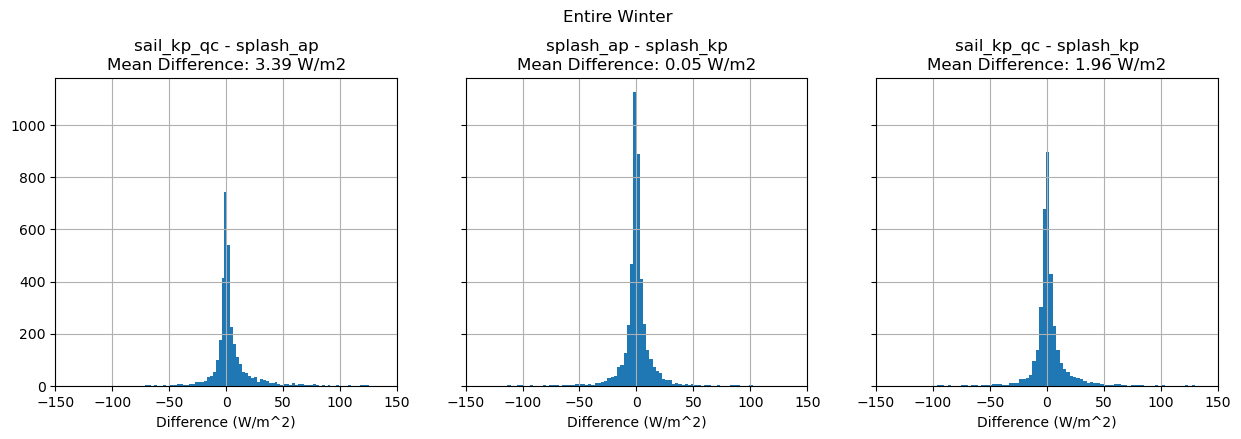

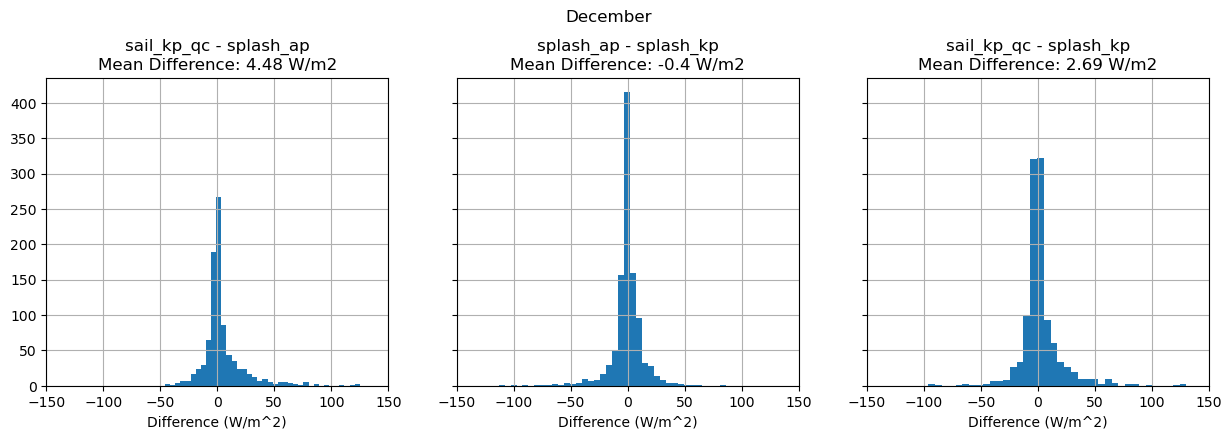

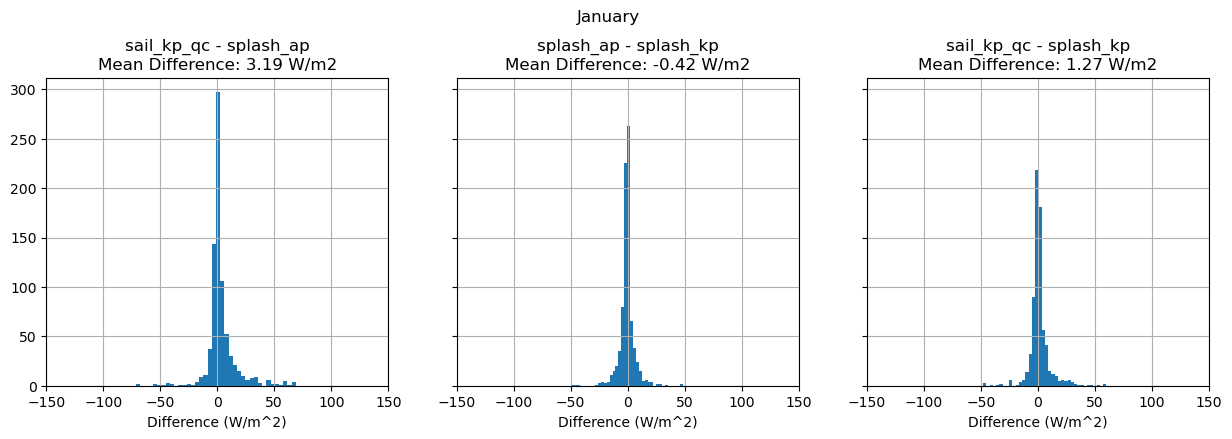

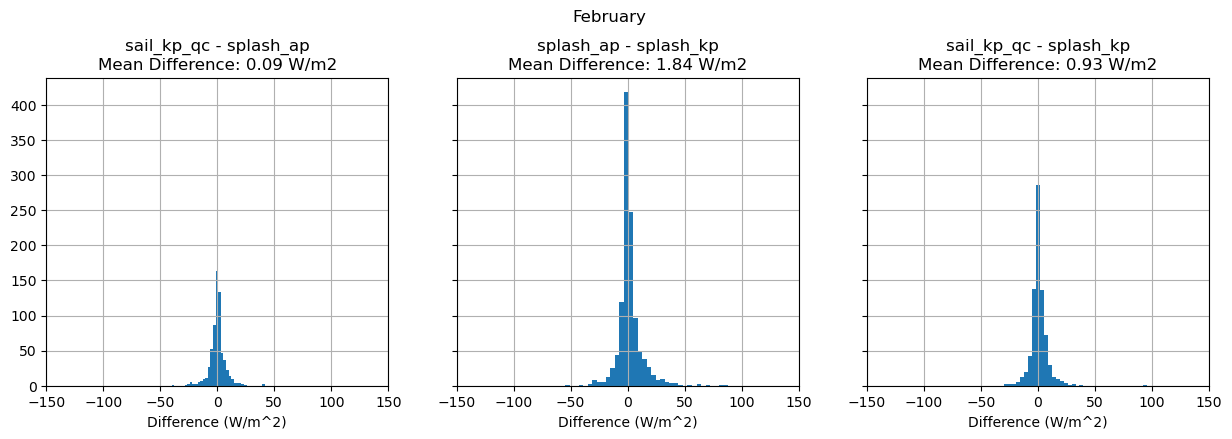

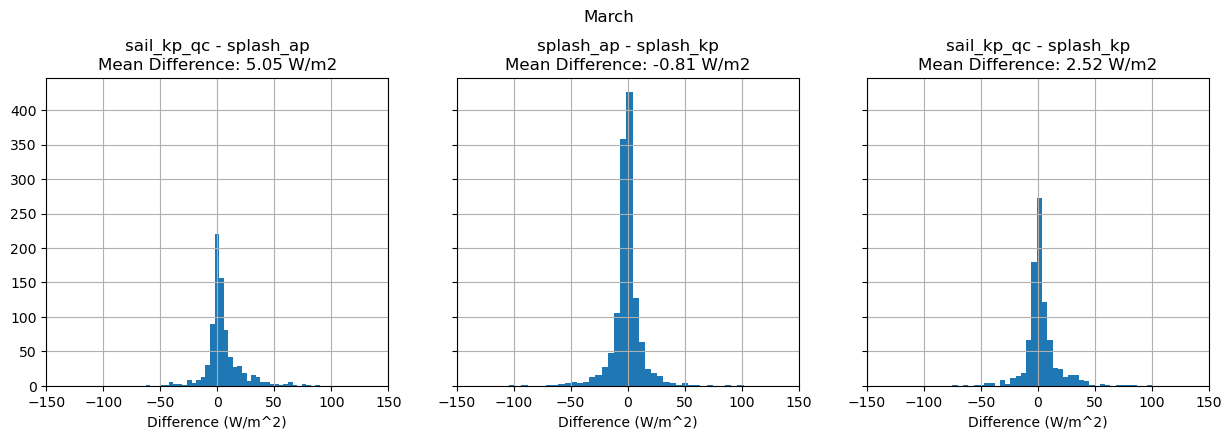

In [36]:
w22_sublimation_df_dec = w22_sublimation_df.loc['2021-12-01':'2021-12-31'].drop(columns=['sail_kp_no_qc'])
w22_sublimation_df_jan = w22_sublimation_df.loc['2022-01-01':'2022-01-31'].drop(columns=['sail_kp_no_qc'])
w22_sublimation_df_feb = w22_sublimation_df.loc['2022-02-01':'2022-02-28'].drop(columns=['sail_kp_no_qc'])
w22_sublimation_df_mar = w22_sublimation_df.loc['2022-03-01':'2022-03-31'].drop(columns=['sail_kp_no_qc'])

# print the number of nans in each column 
print("December \n", w22_sublimation_df_dec.isnull().sum()/len(w22_sublimation_df_dec))
print("January \n", w22_sublimation_df_jan.isnull().sum()/len(w22_sublimation_df_dec))
print("February \n", w22_sublimation_df_feb.isnull().sum()/len(w22_sublimation_df_dec))
print("March \n", w22_sublimation_df_mar.isnull().sum()/len(w22_sublimation_df_dec))


def plot_differences(df, suptitle):
    fig, ax = plt.subplots(1, len(df.columns), figsize=(5*len(df.columns), 4), sharey=True)
    cols = df.columns
    # we're going to loop through and plot a histogram of the differences
    for i, col in enumerate(cols):
        if i == len(cols) - 1:
           difference = df[cols[0]] - df[col]  
           label = f"{cols[0]} - {col}"
        else:
            difference = df[col] - df[cols[i+1]]
            label = f"{col} - {cols[i+1]}"
        ax[i].hist(difference, bins=np.sqrt(len(difference)).astype(int))
        ax[i].set_title(f"{label}\nMean Difference: {difference.mean().round(2)} W/m2")
        ax[i].set_xlabel(label)
        ax[i].set_xlim(-150, 150)
        ax[i].set_xlabel('Difference (W/m^2)')
        ax[i].grid(True)
    fig.suptitle(suptitle, y=1.05)
plot_differences(w22_sublimation_df.drop(columns='sail_kp_no_qc'), suptitle='Entire Winter')    
plot_differences(w22_sublimation_df_dec, suptitle='December')
plot_differences(w22_sublimation_df_jan, suptitle='January')
plot_differences(w22_sublimation_df_feb, suptitle='February')
plot_differences(w22_sublimation_df_mar, suptitle='March')


So, we see some distinct agreements throughout all months. While there generally is variability in time, in every month, we see a peak in the difference in latent heat fluxes of around 0. This tells us that, more often than not, the observations are close to 0.
However, I will note that small latent heat fluxes may dominate in winter, but its important to not have a huge bias during these low periods, so that is good to see. 

Can we use the times when these are in "best-agreement"? 

In [37]:
def all_nans(df):
    """
    Return the percent of rows that are all NANs in a dataframe
    """
    x = df.isnull().sum(axis=1)
    return len(x[x == len(df.columns)])/len(df) * 100
print("How much (%) are we missing all data?")
print("December: " + str(all_nans(w22_sublimation_df_dec)))
print("January: " + str(all_nans(w22_sublimation_df_jan)))
print("February: " + str(all_nans(w22_sublimation_df_feb)))
print("March: " + str(all_nans(w22_sublimation_df_mar)))


How much (%) are we missing all data?
December: 4.637096774193548
January: 4.032258064516129
February: 0.2232142857142857
March: 2.6881720430107525


That might work, we have a pretty limited amount of time where we are missing all our datasets (See above). So if we can build relationships between each when differences are minimized, then that might be good! But how much is too much difference? That could be our error margin, 10 W/m2 would be a certain amount of sublimation over the winter that falls within our error, but if the mean is around 5, choosing a range of 10 W might be too much. 

In [38]:
# groupby by each hour interval and calculate the mean
w22_sublimation_df_hourly = w22_sublimation_df.groupby(w22_sublimation_df.index.hour).mean()
w22_sublimation_df_hourly_dec = w22_sublimation_df_dec.groupby(w22_sublimation_df_dec.index.hour).mean()
w22_sublimation_df_hourly_jan = w22_sublimation_df_jan.groupby(w22_sublimation_df_jan.index.hour).mean()
w22_sublimation_df_hourly_feb = w22_sublimation_df_feb.groupby(w22_sublimation_df_feb.index.hour).mean()
w22_sublimation_df_hourly_mar = w22_sublimation_df_mar.groupby(w22_sublimation_df_mar.index.hour).mean()


# now we will plot each hour
def plot_hourly_plotly(df, title):
    fig = go.Figure()
    for col in df.columns:
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df[col],
                                 mode='lines',
                                 name=col))
    fig.update_layout(title=title,
                        xaxis_title='Hour',
                        yaxis_title='Latent Heat Flux (W/m^2)',
                        width=600,
                        height=500,
                        hovermode='x unified')
    return fig.show()
plot_hourly_plotly(w22_sublimation_df_hourly, title='2022 Winter Hourly Comparison')
plot_hourly_plotly(w22_sublimation_df_hourly_dec, title='2022 Winter Hourly Comparison - December')
plot_hourly_plotly(w22_sublimation_df_hourly_jan, title='2022 Winter Hourly Comparison - January')
plot_hourly_plotly(w22_sublimation_df_hourly_feb, title='2022 Winter Hourly Comparison - February')
plot_hourly_plotly(w22_sublimation_df_hourly_mar, title='2022 Winter Hourly Comparison - March')

### 2023
#### First look at the correlations between variables

In [39]:
w23_sublimation_dict = {
    'splash_ap': w23_splash_ap_qc_30min['Hl'].resample(time='30min').mean(),
    # 'splash_kp': w23_splash_kp_qc_30min['Hl'].resample(time='30min').mean(), skipping since there was no data
    'sos_3m': w23_sos_30min_3m.resample('30min').mean()*latent_heat_sublimation/1000,
    'sos_5m': w23_sos_30min_5m.resample('30min').mean()*latent_heat_sublimation/1000,
    'sos_10m': w23_sos_30min_10m.resample('30min').mean()*latent_heat_sublimation/1000
}
w23_sublimation_dict_other = {
    'sail_kp_no_qc': w23_sail_kp_no_qc['lv_e'].resample(time='30min').mean(),
    'sail_kp_qc': w23_sail_kp_qc['latent_heat_flux'].resample(time='30min').mean(),
}

w23_sublimation_df = pd.DataFrame(w23_sublimation_dict).reset_index()
w23_sublimation_df_other = pd.DataFrame(w23_sublimation_dict_other, index=w23_sail_kp_no_qc['lv_e'].resample(time='30min').mean().time).reset_index()
w23_sublimation_df_other = w23_sublimation_df_other.rename(columns={'index':'time'})
# merge the other dataframes where the longer time series is the index
w23_sublimation_df = pd.merge(w23_sublimation_df, w23_sublimation_df_other, on='time', how='left')
w23_sublimation_df = w23_sublimation_df.set_index('time')
w23_sublimation_df.corr()

splash_ap    sos_3m    sos_5m   sos_10m  sail_kp_no_qc  \
splash_ap       1.000000  0.643820  0.573284  0.525290       0.384856   
sos_3m          0.643820  1.000000  0.661623  0.645996       0.409644   
sos_5m          0.573284  0.661623  1.000000  0.717711       0.432252   
sos_10m         0.525290  0.645996  0.717711  1.000000       0.376586   
sail_kp_no_qc   0.384856  0.409644  0.432252  0.376586       1.000000   
sail_kp_qc      0.511978  0.521858  0.563564  0.474916       0.687808   

               sail_kp_qc  
splash_ap        0.511978  
sos_3m           0.521858  
sos_5m           0.563564  
sos_10m          0.474916  
sail_kp_no_qc    0.687808  
sail_kp_qc       1.000000

Points of interest:

- We see generally good agreement between the SAIL datasets, as expected since the qc data is derived from the no-qc data.
- We see reasonable, yet worse agreement between the SAIL and SPLASH AP data, likely due to less data availability. Very similar correlations for the SOS data as well
- We see higher correlations with the lower sonics w.r.t. the SOS observations.

#### Second, look at any biases between variables

In [40]:
def mean_bias(obs, model):
    return (model - obs).mean()
def mean_absolute_error(obs, model):
    return (np.abs(model - obs)).mean()
def root_mean_squared_error(obs, model):
    return np.sqrt(((model - obs)**2).mean())
def mean_percentage_error(obs, model):
    return (np.abs(model - obs) / obs).mean()
def bias_calculations(obs, model):
    return mean_bias(obs, model), mean_absolute_error(obs, model), root_mean_squared_error(obs, model), mean_percentage_error(obs, model)
# Calculate the mean bias between variables
print("2023 Winter Comparison")
print("SAIL KP Raw Data vs. SAIL KP Data QC")
print(bias_calculations(w23_sublimation_df['sail_kp_no_qc'], w23_sublimation_df['sail_kp_qc']))
print("SAIL KP Data QC vs. SPLASH AP Data")
print(bias_calculations(w23_sublimation_df['sail_kp_qc'], w23_sublimation_df['splash_ap']))
print("SAIL KP Data QC vs. SOS Data 3m")
print(bias_calculations(w23_sublimation_df['sail_kp_qc'], w23_sublimation_df['sos_3m']))
print("SAIL KP Data QC vs. SOS Data 5m")
print(bias_calculations(w23_sublimation_df['sail_kp_qc'], w23_sublimation_df['sos_5m']))
print("SAIL KP Data QC vs. SOS Data 10m")
print(bias_calculations(w23_sublimation_df['sail_kp_qc'], w23_sublimation_df['sos_10m']))
print("SPLASH AP Data vs. SOS Data 3m")
print(bias_calculations(w23_sublimation_df['splash_ap'], w23_sublimation_df['sos_3m']))
print("SPLASH AP Data vs. SOS Data 5m")
print(bias_calculations(w23_sublimation_df['splash_ap'], w23_sublimation_df['sos_5m']))
print("SPLASH AP Data vs. SOS Data 10m")
print(bias_calculations(w23_sublimation_df['splash_ap'], w23_sublimation_df['sos_10m']))
print("SOS Data 3m vs. SOS Data 5m")
print(bias_calculations(w23_sublimation_df['sos_3m'], w23_sublimation_df['sos_5m']))
print("SOS Data 3m vs. SOS Data 10m")
print(bias_calculations(w23_sublimation_df['sos_3m'], w23_sublimation_df['sos_10m']))
print("SOS Data 5m vs. SOS Data 10m")
print(bias_calculations(w23_sublimation_df['sos_5m'], w23_sublimation_df['sos_10m']))


2023 Winter Comparison
SAIL KP Raw Data vs. SAIL KP Data QC
(2.2572906, 6.3507853, 21.055794, 1.1982057)
SAIL KP Data QC vs. SPLASH AP Data
(-8.37550919347804, 14.74402221629814, 27.865096048441714, 0.12402709960924288)
SAIL KP Data QC vs. SOS Data 3m
(-4.575276366173527, 10.895672149897798, 23.75673980440121, -0.06978475306141566)
SAIL KP Data QC vs. SOS Data 5m
(-3.977487338608478, 10.781323817478873, 22.796226852686512, 0.6579637226145211)
SAIL KP Data QC vs. SOS Data 10m
(-3.7459526490384794, 12.012039977903365, 24.421045850511142, 0.4318665283428706)
SPLASH AP Data vs. SOS Data 3m
(2.2720552222621193, 6.414140873964104, 11.296394689045774, 0.06387631064331696)
SPLASH AP Data vs. SOS Data 5m
(2.792831288628833, 7.268123915263132, 13.034396732880976, -0.024319461071548677)
SPLASH AP Data vs. SOS Data 10m
(2.5842690645775797, 8.73941497794365, 15.11306081028696, -0.8000764397187985)
SOS Data 3m vs. SOS Data 5m
(0.45189260649284946, 3.8482867894594004, 12.10823923839475, -2.4926715146

Here is a summary of the results:
2023 Winter Comparison

- SAIL KP Raw Data vs. SAIL KP Data QC
    - Mean Bias: 2.25
    - MAE: 6.35
    - RMSE: 21.0
    - MPE: 1.19
- SAIL KP Data QC vs. SPLASH AP Data
    - Mean Bias: -8.3
    - MAE: 14.7
    - RMSE: 27.86
    - MPE: 0.1240
- SAIL KP Data QC vs. SOS Data 3m
    - Mean Bias: -4.57
    - MAE: 10.89
    - RMSE: 23.7
    - MPE: -0.0697
- SAIL KP Data QC vs. SOS Data 5m
    - Mean Bias: -3.97
    - MAE: 10.78
    - RMSE: 22.79
    - MPE: 0.657
- SAIL KP Data QC vs. SOS Data 10m
    - Mean Bias: -3.745
    - MAE: 12.01
    - RMSE: 24.42
    - MPE: 0.431
- SPLASH AP Data vs. SOS Data 3m
    - Mean Bias: 2.272
    - MAE: 6.41
    - RMSE: 11.29
    - MPE: 0.0638
- SPLASH AP Data vs. SOS Data 5m
    - Mean Bias: 2.79
    - MAE: 7.26
    - RMSE: 13.03
    - MPE: -0.02431
- SPLASH AP Data vs. SOS Data 10m
    - Mean Bias: 2.584
    - MAE: 8.7
    - RMSE: 15.1
    - MPE: -0.800
- SOS Data 3m vs
    - Mean Bias: 0.4518
    - MAE: 3.848
    - RMSE: 12.1
    - MPE: -2.492
- SOS Data 3m vs.
    - Mean Bias: 0.556
    - MAE: 5.66
    - RMSE: 12.92
    - MPE: -3.718
- SOS Data 5m vs.
    - Mean Bias: 0.307
    - MAE: 4.71
    - RMSE: 11.71
    - MPE: 2.26

#### Third, look at biases month by month and throughout each day
- are there times when biases are greater or less? 

December 
 splash_ap     0.280914
sos_3m        0.022849
sos_5m        0.020833
sos_10m       0.033602
sail_kp_qc    0.092070
dtype: float64
January 
 splash_ap     0.633065
sos_3m        0.083333
sos_5m        0.053091
sos_10m       0.068548
sail_kp_qc    0.186156
dtype: float64
February 
 splash_ap     0.692876
sos_3m        0.018145
sos_5m        0.013441
sos_10m       0.012769
sail_kp_qc    0.054435
dtype: float64
March 
 splash_ap     0.830645
sos_3m        0.073253
sos_5m        0.030242
sos_10m       0.068548
sail_kp_qc    0.334005
dtype: float64


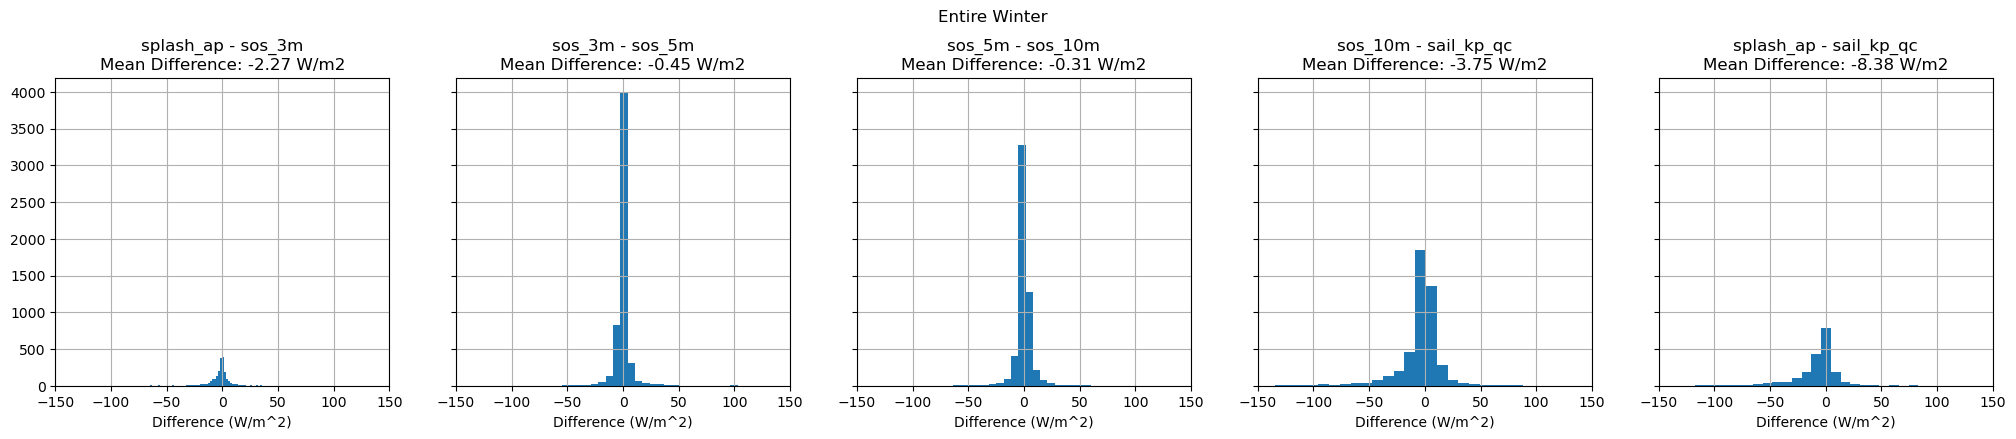

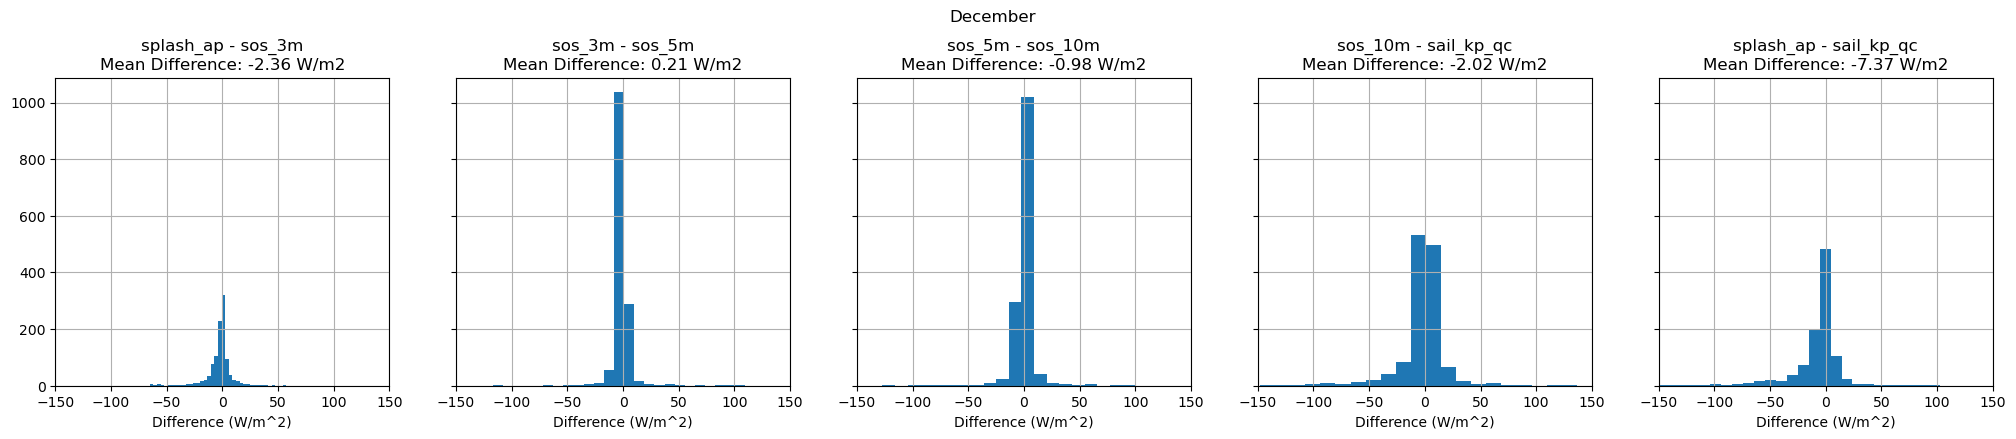

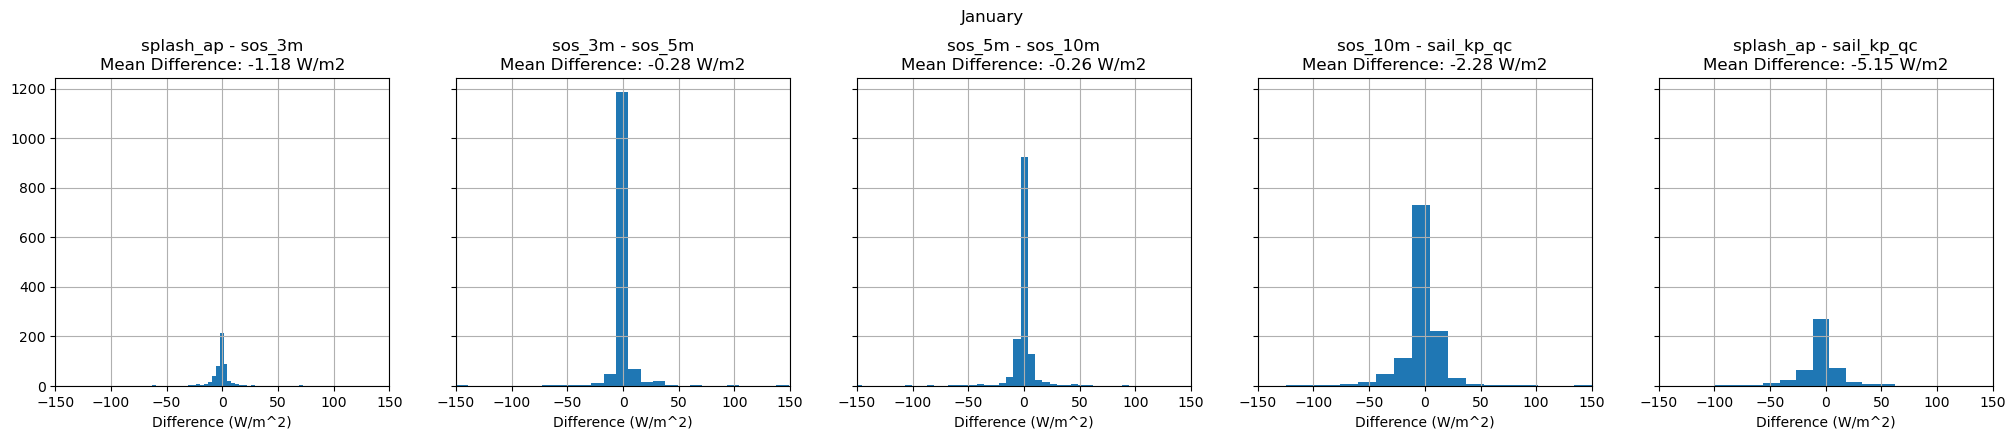

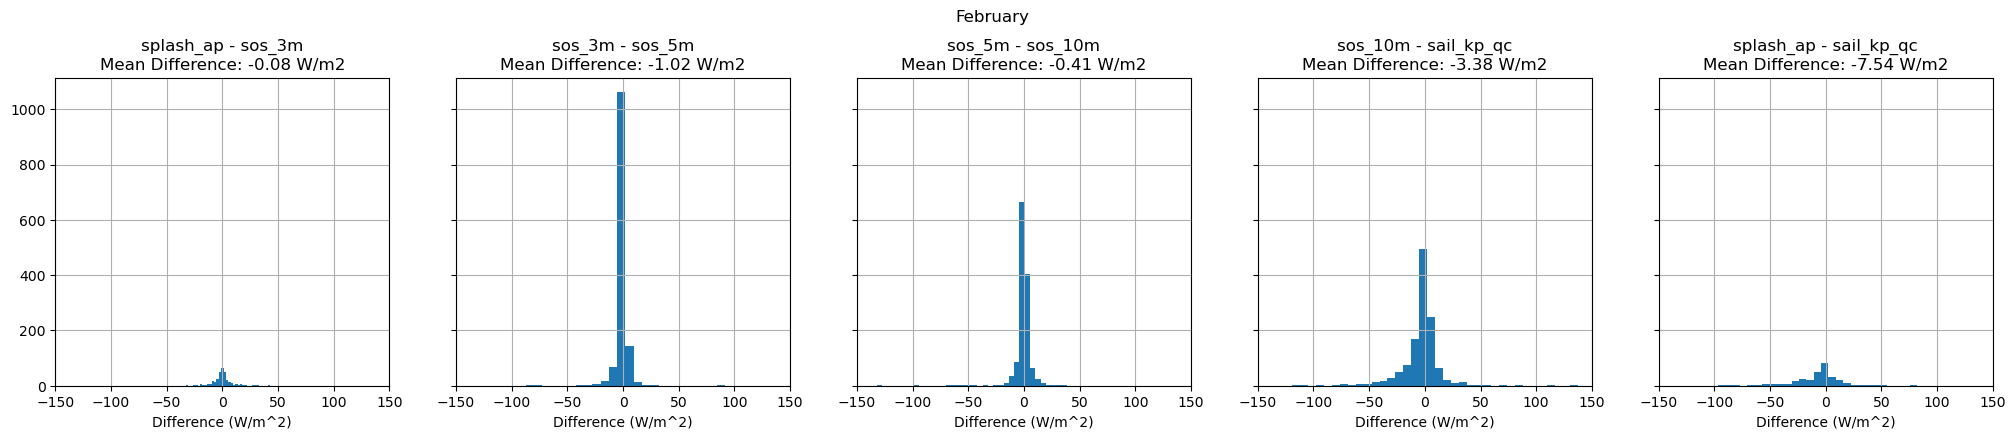

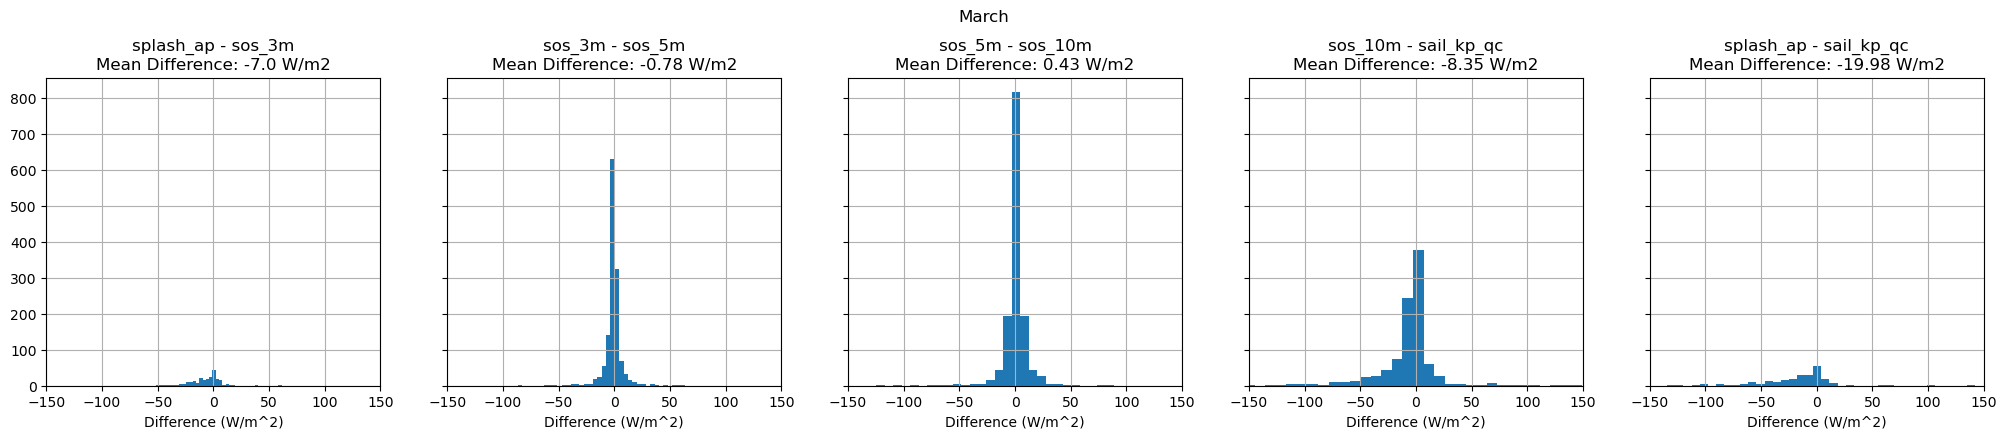

In [41]:
w23_sublimation_df_dec = w23_sublimation_df.loc['2022-12-01':'2022-12-31'].drop(columns=['sail_kp_no_qc'])
w23_sublimation_df_jan = w23_sublimation_df.loc['2023-01-01':'2023-01-31'].drop(columns=['sail_kp_no_qc'])
w23_sublimation_df_feb = w23_sublimation_df.loc['2023-02-01':'2023-02-28'].drop(columns=['sail_kp_no_qc'])
w23_sublimation_df_mar = w23_sublimation_df.loc['2023-03-01':'2023-03-31'].drop(columns=['sail_kp_no_qc'])

# print the number of nans in each column 
print("December \n", w23_sublimation_df_dec.isnull().sum()/len(w23_sublimation_df_dec))
print("January \n", w23_sublimation_df_jan.isnull().sum()/len(w23_sublimation_df_dec))
print("February \n", w23_sublimation_df_feb.isnull().sum()/len(w23_sublimation_df_dec))
print("March \n", w23_sublimation_df_mar.isnull().sum()/len(w23_sublimation_df_dec))


def plot_differences(df, suptitle):
    fig, ax = plt.subplots(1, len(df.columns), figsize=(5*len(df.columns), 4), sharey=True)
    cols = df.columns
    # we're going to loop through and plot a histogram of the differences
    for i, col in enumerate(cols):
        if i == len(cols) - 1:
           difference = df[cols[0]] - df[col]  
           label = f"{cols[0]} - {col}"
        else:
            difference = df[col] - df[cols[i+1]]
            label = f"{col} - {cols[i+1]}"
        ax[i].hist(difference, bins=np.sqrt(len(difference)).astype(int))
        ax[i].set_title(f"{label}\nMean Difference: {difference.mean().round(2)} W/m2")
        ax[i].set_xlabel(label)
        ax[i].set_xlim(-150, 150)
        ax[i].set_xlabel('Difference (W/m^2)')
        ax[i].grid(True)
    fig.suptitle(suptitle, y=1.05)
plot_differences(w23_sublimation_df.drop(columns='sail_kp_no_qc'), suptitle='Entire Winter')    
plot_differences(w23_sublimation_df_dec, suptitle='December')
plot_differences(w23_sublimation_df_jan, suptitle='January')
plot_differences(w23_sublimation_df_feb, suptitle='February')
plot_differences(w23_sublimation_df_mar, suptitle='March')


So, we see some distinct agreements throughout all months. While there generally is variability in time, in every month, we see a peak in the difference in latent heat fluxes of around 0. This tells us that, more often than not, the observations are close to 0.
However, I will note that small latent heat fluxes may dominate in winter, but its important to not have a huge bias during these low periods, so that is good to see. 

Can we use the times when these are in "best-agreement"? 

In [42]:
def all_nans(df):
    """
    Return the percent of rows that are all NANs in a dataframe
    """
    x = df.isnull().sum(axis=1)
    return len(x[x == len(df.columns)])/len(df) * 100
print("How much (%) are we missing all data?")
print("December: " + str(all_nans(w23_sublimation_df_dec)))
print("January: " + str(all_nans(w23_sublimation_df_jan)))
print("February: " + str(all_nans(w23_sublimation_df_feb)))
print("March: " + str(all_nans(w23_sublimation_df_mar)))


How much (%) are we missing all data?
December: 1.0080645161290323
January: 1.9489247311827957
February: 0.5952380952380952
March: 2.28494623655914


That might work, we have a pretty limited amount of time where we are missing all our datasets (See above). So if we can build relationships between each when differences are minimized, then that might be good! But how much is too much difference? That could be our error margin, 10 W/m2 would be a certain amount of sublimation over the winter that falls within our error, but if the mean is around 5, choosing a range of 10 W might be too much. 

In [43]:
# groupby by each hour interval and calculate the mean
w23_sublimation_df_hourly = w23_sublimation_df.groupby(w23_sublimation_df.index.hour).mean().drop(columns='sail_kp_no_qc')
w23_sublimation_df_hourly_dec = w23_sublimation_df_dec.groupby(w23_sublimation_df_dec.index.hour).mean()
w23_sublimation_df_hourly_jan = w23_sublimation_df_jan.groupby(w23_sublimation_df_jan.index.hour).mean()
w23_sublimation_df_hourly_feb = w23_sublimation_df_feb.groupby(w23_sublimation_df_feb.index.hour).mean()
w23_sublimation_df_hourly_mar = w23_sublimation_df_mar.groupby(w23_sublimation_df_mar.index.hour).mean()


# now we will plot each hour
def plot_hourly_plotly(df, title):
    fig = go.Figure()
    for col in df.columns:
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df[col],
                                 mode='lines',
                                 name=col))
    fig.update_layout(title=title,
                        xaxis_title='Hour',
                        yaxis_title='Latent Heat Flux (W/m^2)',
                        width=600,
                        height=500,
                        hovermode='x unified')
    return fig.show()
plot_hourly_plotly(w23_sublimation_df_hourly, title='2023 Winter Hourly Comparison')
plot_hourly_plotly(w23_sublimation_df_hourly_dec, title='2023 Winter Hourly Comparison - December')
plot_hourly_plotly(w23_sublimation_df_hourly_jan, title='2023 Winter Hourly Comparison - January')
plot_hourly_plotly(w23_sublimation_df_hourly_feb, title='2023 Winter Hourly Comparison - February')
plot_hourly_plotly(w23_sublimation_df_hourly_mar, title='2023 Winter Hourly Comparison - March')

# Generally speaking it seems that the SAIL dataset has greater sensitivity

<Axes: >

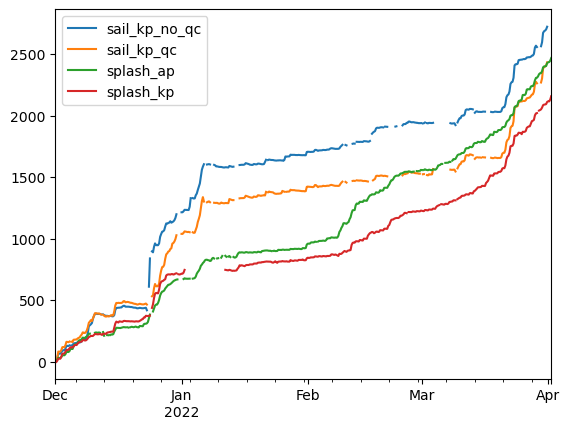

In [44]:
w22_sublimation_df.resample('6H').mean().cumsum().plot()

Although, if we just look at the availability of data, we see that we have a generally continuous measurement of latent heat flux at Avery Picnic. What if we use a relationship between Avery Picnic and Kettle Ponds to fill in the blanks?

### START HERE!
Looking at the relationship between variables in 2022. Does KP and AP have the same slope as in 2023? Is that our "site-specific" difference? 

In [45]:
# These functions will help us resample and filter the data to show how these data relate with different averaging lengths.
def resample_and_filter_df(df, averaging_length, percent_drop, dropna=True):
    averaging_length_text = f'{averaging_length}H'
    nsamples = 2*averaging_length
    # Resample and count valid data, then use that to filter the data
    df_count = df.resample(averaging_length_text).count()
    df_filtered = df.resample(averaging_length_text).mean().where(df_count >= int(nsamples*percent_drop))
    if dropna:
        return df_filtered.dropna()
    else:
        return df_filtered

def resample_and_combine_dfs(dfs, averaging_length, percent_drop=0.9, drop_extremes=False):
    """
    Resample and filter the dataframes and then combine them into one dataframe
    input: dfs - list of dataframes
              averaging_length - the length of the averaging window
              percent_drop - the percent of data that must be present in each window       
              
    """
    dfs_filtered = [resample_and_filter_df(df, averaging_length, percent_drop) for df in dfs]
    combined_df = pd.concat(dfs_filtered)
    if drop_extremes != False:
        if drop_extremes == 'upper':
            combined_df = combined_df.where(combined_df<=combined_df.quantile(0.95))
        elif drop_extremes == 'lower':
            combined_df = combined_df.where(combined_df>=combined_df.quantile(0.05))
        elif drop_extremes == 'both':
            combined_df = combined_df.where((combined_df>=combined_df.quantile(0.05)) & (combined_df<=combined_df.quantile(0.95)))
        else:
            print("Invalid drop_extreme value. Must be 'upper', 'lower', or 'both'")
            return
    return combined_df

def get_resampled_comparison_stats(combineddf, col_to_compare='splash_ap'):
    """
    Evaluate the performance for the averaging time period
    """
    results_dict = {}
    for col in combineddf.columns:
        if col != col_to_compare:
            tmp_df = combineddf[[col, col_to_compare]].dropna()
            mb, mae, rmse, mpe  = bias_calculations(tmp_df[col], tmp_df[col_to_compare])
            slope, intercept, r_value, p_value, std_err = stats.linregress(tmp_df[col].dropna(), tmp_df[col_to_compare])
            results_dict[col] = [mb, mae, rmse, mpe, slope, r_value**2]
    return pd.DataFrame(results_dict, index=['mb', 'mae', 'rmse', 'mpe', 'slope', 'r2'])

def get_all_all_resampling_results(list_of_dfs, resampling_lengths, col_to_compare='splash_ap', drop_extremes='upper'):
    """
    This function will iterate through the resampling lengths and return a dataframe with the stats results
    """
    # iterate through the resampling lengths and 
    all_results_dict = {}
    for rl in resampling_lengths:
        stats_df = get_resampled_comparison_stats(resample_and_combine_dfs(list_of_dfs, rl, drop_extremes=drop_extremes), col_to_compare=col_to_compare)
        for col in stats_df.columns:
            if col != col_to_compare:
                all_results_dict[(col, rl)] = stats_df[col]
    return pd.DataFrame(all_results_dict).T


### 2022 Results

In [46]:
df_test = w22_sublimation_df.drop(columns='sail_kp_no_qc').loc['2021-12-01':'2022-03-31']


mb       mae       rmse       mpe     slope        r2
sail_kp_qc 0.5  -2.541529  6.851860  13.029716  0.264550  0.523177  0.477418
splash_ap  0.5   1.152736  5.228248  10.155793 -0.818481  0.970104  0.434591
sail_kp_qc 1.0  -2.599152  6.414116  11.972470 -6.235929  0.539339  0.525560
splash_ap  1.0   0.961428  4.709643   9.030894  0.335956  0.986224  0.492175
sail_kp_qc 3.0  -2.617112  5.404745   9.894139 -0.603240  0.583640  0.625842
splash_ap  3.0   0.950533  3.902288   7.339887 -0.382589  1.104760  0.598826
sail_kp_qc 6.0  -2.592945  4.314064   7.736774  0.602215  0.595143  0.692561
splash_ap  6.0   0.890713  3.435677   5.843909 -6.497876  1.108174  0.612293
sail_kp_qc 12.0 -3.766093  4.789330   7.364782  0.328178  0.630847  0.783834
splash_ap  12.0  0.481337  3.409544   5.614461  7.282729  1.155564  0.631462
sail_kp_qc 24.0 -8.126247  8.126247   9.599554  0.386564  0.932492  0.564215
splash_ap  24.0  3.573104  4.896685   6.131303  0.556670  1.556485  0.752788

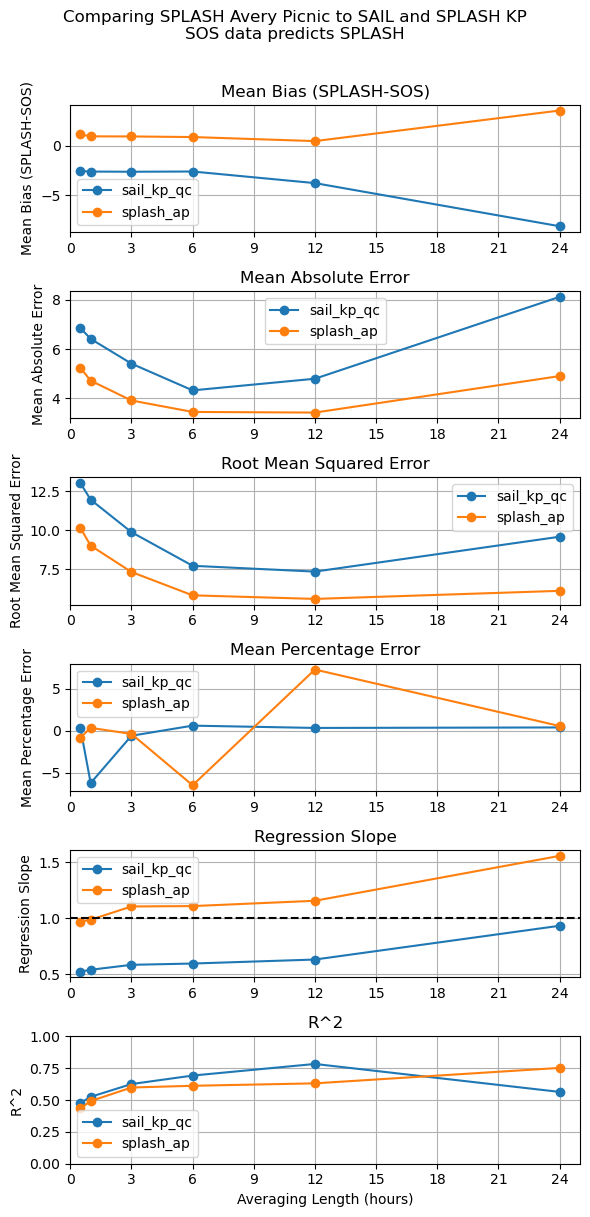

In [47]:
resampling_lengths = [0.5,1,3,6,12,24]
all_results = get_all_all_resampling_results([df_test], resampling_lengths, col_to_compare='splash_kp', drop_extremes='lower')
# now plot the results for each unique index
fig, axs = plt.subplots(len(all_results.columns), 1, figsize=(6,12), tight_layout=True, )
titles = ['Mean Bias (SPLASH-SOS)', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Percentage Error', 'Regression Slope', 'R^2']
for i, col in enumerate(all_results.columns):
    for idx in all_results.index.get_level_values(0).unique():
        axs[i].plot(all_results.loc[idx].index, all_results.loc[idx][col], marker='o', label=idx)
    axs[i].set_title(titles[i])
    
    axs[i].set_ylabel(titles[i])
    axs[i].grid(True)
    axs[i].legend()
    if i == 5:
        axs[i].set_ylim(0,1)  
        axs[i].set_xlabel('Averaging Length (hours)')
    elif i == 4:
        # axs[i].set_ylim(0.8,1.4)
        axs[i].axhline(1, color='black', linestyle='--')
    for ax in axs:
        # make x-ticks labels 0-24 by 3
        ax.set_xticks(np.arange(0, 25, 3))
        ax.set_xlim(0,25)
fig.suptitle('Comparing SPLASH Avery Picnic to SAIL and SPLASH KP\nSOS data predicts SPLASH', y=1.01)
all_results



#### Try to fill in 2022 uncertainty
- using 6-hour averages and the relationship between SPLASH Kettle Ponds and Avery Picnic
- propogate errors to look at the uncertainty

In [48]:
# create the 6-hour product, and only keep the splash columns
w22_sublimation_df_6H_splash = resample_and_filter_df(w22_sublimation_df, 6, 0.8, dropna=False).drop(columns='sail_kp_no_qc')

# since splash AP is the refence, lets linearly interpret missing values
w22_sublimation_df_6H_splash = w22_sublimation_df_6H_splash.interpolate(method='linear', limit=1) 
# for the remaining values, put in rolling 7-day mean
w22_sublimation_df_6H_splash = w22_sublimation_df_6H_splash.fillna(w22_sublimation_df_6H_splash.rolling(8,min_periods=1, center=True).mean())
(w22_sublimation_df_6H_splash.cumsum()*86400/latent_heat_sublimation/4)

sail_kp_qc  splash_ap  splash_kp
2021-12-01 00:00:00    0.037242   0.059954  -0.014444
2021-12-01 06:00:00    0.070462   0.096289  -0.005637
2021-12-01 12:00:00    0.252101   0.149002   0.082248
2021-12-01 18:00:00    0.340943   0.258544   0.206139
2021-12-02 00:00:00    0.336987   0.251929   0.209234
...                         ...        ...        ...
2022-03-31 18:00:00   17.227191  19.551904  16.891347
2022-04-01 00:00:00   17.296553  19.602215  16.928535
2022-04-01 06:00:00   17.355217  19.665518  16.925238
2022-04-01 12:00:00   17.431634  19.741813  17.032253
2022-04-01 18:00:00   17.508052  19.910288  17.245010

[488 rows x 3 columns]

### Compare 2023 SOS to AP
How well do these compare when we have decent observations

In [49]:

# First period of strong agreement between the datasets
p0 = w23_sublimation_df[['splash_ap','sos_3m','sos_5m','sos_10m']].loc['2022-12-23':'2023-01-03 00']#['2022-12-02':'2022-12-20 00']
p1 = w23_sublimation_df[['splash_ap','sos_3m','sos_5m','sos_10m']].loc['2023-01-10':'2023-01-15 00']#['2022-12-23':'2023-01-19 00']
p2 = w23_sublimation_df[['splash_ap','sos_3m','sos_5m','sos_10m']].loc['2023-02-22':'2023-02-27 00']#['2023-02-22':'2023-03-07 12']


mb       mae      rmse         mpe     slope        r2
sos_3m  0.5   0.019134  3.484241  5.442766   -0.185370  0.455253  0.309247
sos_5m  0.5  -0.299619  4.283658  6.413329    0.543760  0.356492  0.251411
sos_10m 0.5  -0.572653  4.983204  7.976462    0.483404  0.247391  0.167153
sos_3m  1.0   0.066913  3.117068  4.943420   -2.386639  0.478431  0.349427
sos_5m  1.0  -0.198019  3.835627  5.762303   11.797512  0.395939  0.324017
sos_10m 1.0  -0.458802  4.145609  6.712697 -226.285788  0.312246  0.240130
sos_3m  3.0  -0.077967  2.151674  3.134862  -59.017103  0.688698  0.595904
sos_5m  3.0  -0.620598  2.754158  4.031951    0.234421  0.544485  0.525482
sos_10m 3.0  -1.291689  2.987823  4.196357    0.317247  0.540577  0.554577
sos_3m  6.0  -0.142442  1.861862  2.447604   -2.010616  0.713821  0.688646
sos_5m  6.0  -0.611853  2.210079  3.048023    0.440446  0.599220  0.669023
sos_10m 6.0  -1.273287  2.177106  3.072002    0.622441  0.619783  0.717555
sos_3m  12.0 -0.411291  1.494646  2.075574    0.295320  0.858031  0.691796
sos_5m  12.0 -0.995292  1.814526  2.459443    0.401728  0.743280  0.681481
sos_10m 12.0 -1.314720  1.946215  2.685405    0.394958  0.682158  0.723742
sos_3m  24.0 -0.367735  1.136824  1.744535    0.304152  0.641725  0.496077
sos_5m  24.0 -0.703286  1.413518  1.892902    0.779174  0.580050  0.631771
sos_10m 24.0 -0.815171  1.329804  1.779293   -0.070666  0.598872  0.786359

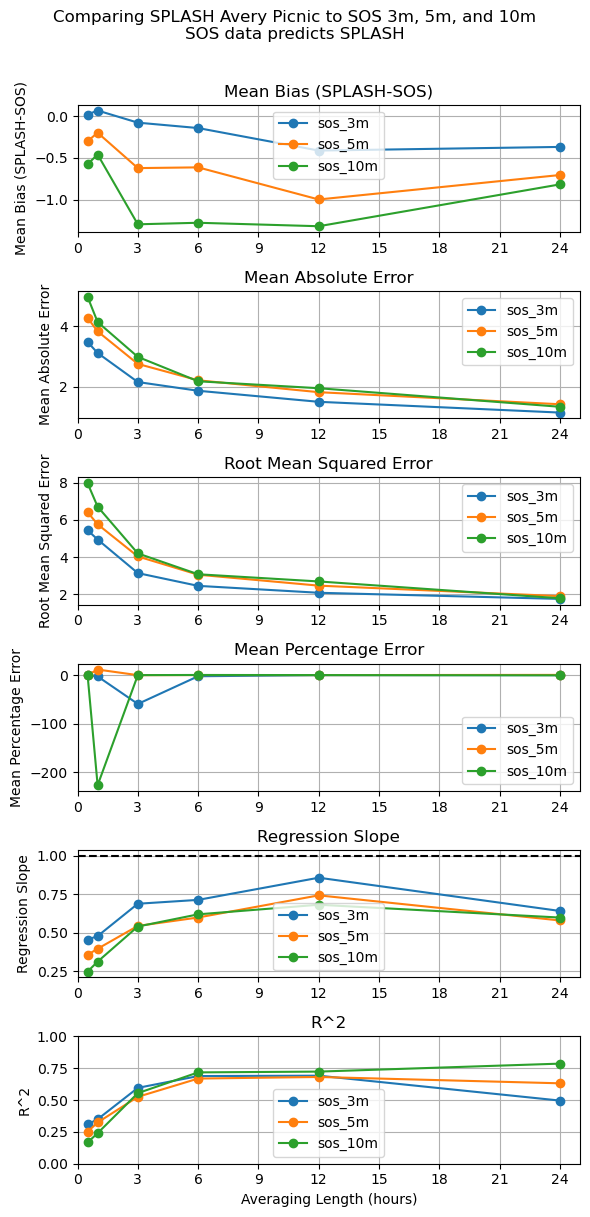

In [50]:
resampling_lengths = [0.5,1,3,6,12,24]
all_results = get_all_all_resampling_results([p0, p2], resampling_lengths)
# now plot the results for each unique index
fig, axs = plt.subplots(len(all_results.columns), 1, figsize=(6,12), tight_layout=True, )
titles = ['Mean Bias (SPLASH-SOS)', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Percentage Error', 'Regression Slope', 'R^2']
for i, col in enumerate(all_results.columns):
    for idx in all_results.index.get_level_values(0).unique():
        axs[i].plot(all_results.loc[idx].index, all_results.loc[idx][col], marker='o', label=idx)
    axs[i].set_title(titles[i])
    
    axs[i].set_ylabel(titles[i])
    axs[i].grid(True)
    axs[i].legend()
    if i == 5:
        axs[i].set_ylim(0,1)  
        axs[i].set_xlabel('Averaging Length (hours)')
    elif i == 4:
        # axs[i].set_ylim(0.8,1.4)
        axs[i].axhline(1, color='black', linestyle='--')
    for ax in axs:
        # make x-ticks labels 0-24 by 3
        ax.set_xticks(np.arange(0, 25, 3))
        ax.set_xlim(0,25)
fig.suptitle('Comparing SPLASH Avery Picnic to SOS 3m, 5m, and 10m\nSOS data predicts SPLASH', y=1.01)
all_results



In [51]:

averaging_length= 6
averaging_length_text = f'{averaging_length}H'
nsamples = 2*averaging_length

p0_counts = p0.resample(averaging_length_text).count()
p1_counts = p1.resample(averaging_length_text).count()
p2_counts = p2.resample(averaging_length_text).count()

p0_w23_sublimation_df = p0.resample(averaging_length_text).mean().where(p0_counts >= int(nsamples*1)).dropna()
p1_w23_sublimation_df = p1.resample(averaging_length_text).mean().where(p1_counts >= int(nsamples*1)).dropna()
p2_w23_sublimation_df = p2.resample(averaging_length_text).mean().where(p2_counts >= int(nsamples*1)).dropna()
# we'll drop the top 5% of the data to remove extreme outliers. 
p0_w23_sublimation_df = p0_w23_sublimation_df.where(p0_w23_sublimation_df<=p0_w23_sublimation_df.quantile(0.95)).dropna()
p1_w23_sublimation_df = p1_w23_sublimation_df.where(p1_w23_sublimation_df<=p1_w23_sublimation_df.quantile(0.95)).dropna()
p2_w23_sublimation_df = p2_w23_sublimation_df.where(p2_w23_sublimation_df<=p2_w23_sublimation_df.quantile(0.95)).dropna()
combined_periods = resample_and_combine_dfs([p0, p1, p2], 6)
combined_periods = combined_periods.where(combined_periods<=combined_periods.quantile(0.95)).dropna()

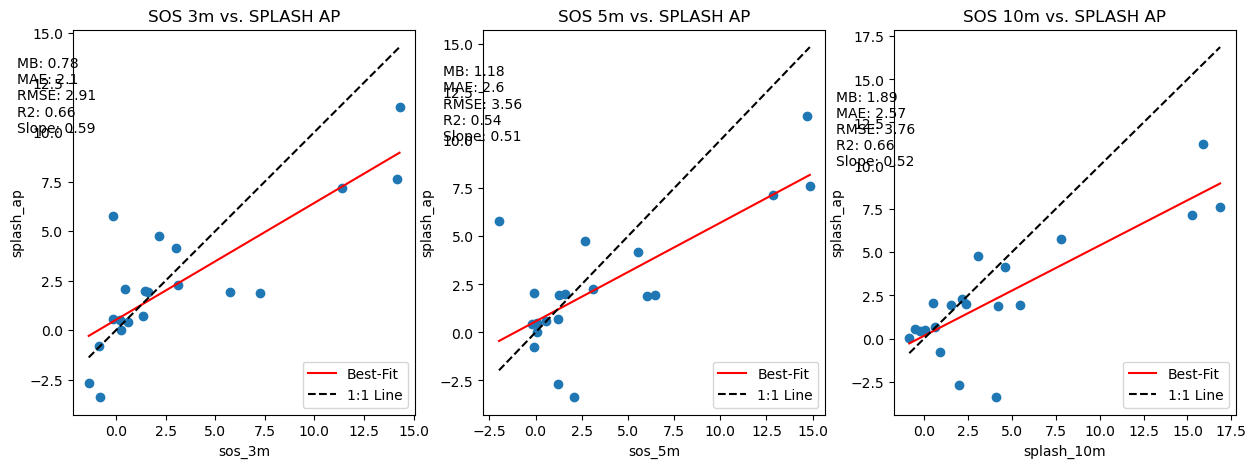

In [52]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax = axs[0]
ax.scatter(p0_w23_sublimation_df['sos_3m'], p0_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p0_w23_sublimation_df['sos_3m'], p0_w23_sublimation_df['splash_ap'])
x = np.array([p0_w23_sublimation_df['sos_3m'].min(), p0_w23_sublimation_df['sos_3m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
# plot 1:1 line
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_3m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 3m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(p0_w23_sublimation_df['splash_ap'], p0_w23_sublimation_df['sos_3m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[1]
ax.scatter(p0_w23_sublimation_df['sos_5m'], p0_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p0_w23_sublimation_df['sos_5m'], p0_w23_sublimation_df['splash_ap'])
x = np.array([p0_w23_sublimation_df['sos_5m'].min(), p0_w23_sublimation_df['sos_5m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_5m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 5m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(p0_w23_sublimation_df['splash_ap'], p0_w23_sublimation_df['sos_5m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[2]
ax.scatter(p0_w23_sublimation_df['sos_10m'], p0_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p0_w23_sublimation_df['sos_10m'], p0_w23_sublimation_df['splash_ap'])
x = np.array([p0_w23_sublimation_df['sos_10m'].min(), p0_w23_sublimation_df['sos_10m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('splash_10m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 10m vs. SPLASH AP')
# annotate the RMSE, R2, bias, and slope
mb, mae, rmse, mpe = bias_calculations(p0_w23_sublimation_df['splash_ap'], p0_w23_sublimation_df['sos_10m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")


for ax in axs:
    ax.legend(loc='lower right')

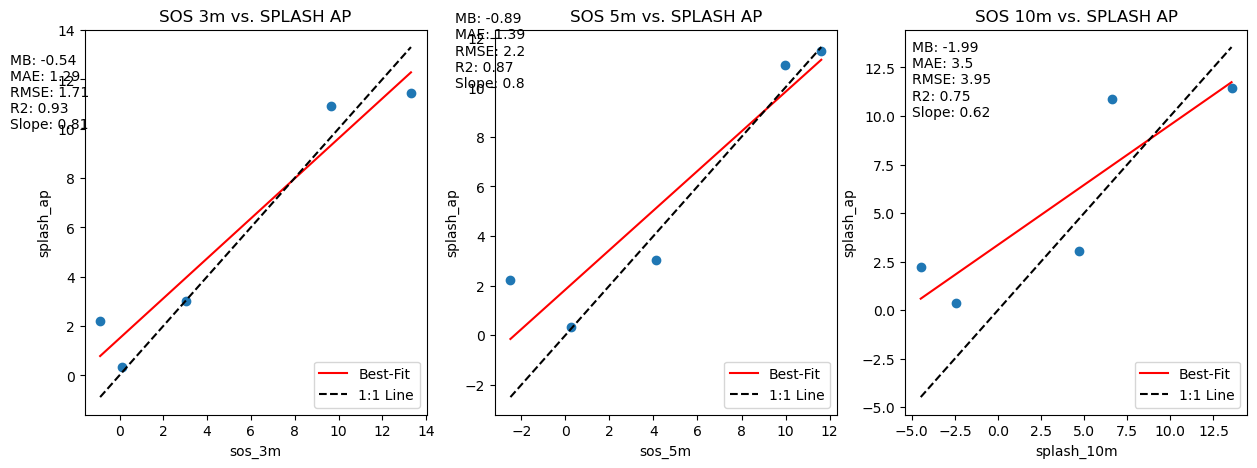

In [53]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax = axs[0]
ax.scatter(p1_w23_sublimation_df['sos_3m'], p1_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p1_w23_sublimation_df['sos_3m'], p1_w23_sublimation_df['splash_ap'])
x = np.array([p1_w23_sublimation_df['sos_3m'].min(), p1_w23_sublimation_df['sos_3m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
# plot 1:1 line
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_3m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 3m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(p1_w23_sublimation_df['splash_ap'], p1_w23_sublimation_df['sos_3m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[1]
ax.scatter(p1_w23_sublimation_df['sos_5m'], p1_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p1_w23_sublimation_df['sos_5m'], p1_w23_sublimation_df['splash_ap'])
x = np.array([p1_w23_sublimation_df['sos_5m'].min(), p1_w23_sublimation_df['sos_5m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_5m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 5m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(p1_w23_sublimation_df['splash_ap'], p1_w23_sublimation_df['sos_5m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[2]
ax.scatter(p1_w23_sublimation_df['sos_10m'], p1_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p1_w23_sublimation_df['sos_10m'], p1_w23_sublimation_df['splash_ap'])
x = np.array([p1_w23_sublimation_df['sos_10m'].min(), p1_w23_sublimation_df['sos_10m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('splash_10m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 10m vs. SPLASH AP')
# annotate the RMSE, R2, bias, and slope
mb, mae, rmse, mpe = bias_calculations(p1_w23_sublimation_df['splash_ap'], p1_w23_sublimation_df['sos_10m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")


for ax in axs:
    ax.legend(loc='lower right')

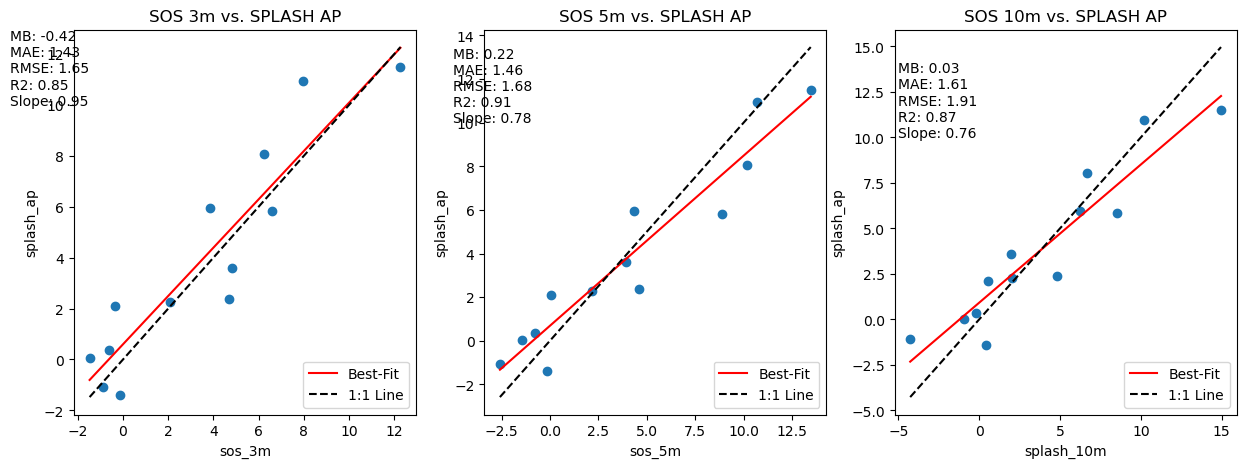

In [54]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax = axs[0]
ax.scatter(p2_w23_sublimation_df['sos_3m'], p2_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p2_w23_sublimation_df['sos_3m'], p2_w23_sublimation_df['splash_ap'])
x = np.array([p2_w23_sublimation_df['sos_3m'].min(), p2_w23_sublimation_df['sos_3m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
# plot 1:1 line
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_3m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 3m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(p2_w23_sublimation_df['splash_ap'], p2_w23_sublimation_df['sos_3m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[1]
ax.scatter(p2_w23_sublimation_df['sos_5m'], p2_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p2_w23_sublimation_df['sos_5m'], p2_w23_sublimation_df['splash_ap'])
x = np.array([p2_w23_sublimation_df['sos_5m'].min(), p2_w23_sublimation_df['sos_5m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_5m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 5m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(p2_w23_sublimation_df['splash_ap'], p2_w23_sublimation_df['sos_5m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[2]
ax.scatter(p2_w23_sublimation_df['sos_10m'], p2_w23_sublimation_df['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(p2_w23_sublimation_df['sos_10m'], p2_w23_sublimation_df['splash_ap'])
x = np.array([p2_w23_sublimation_df['sos_10m'].min(), p2_w23_sublimation_df['sos_10m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('splash_10m')
ax.set_ylabel('splash_ap')
ax.set_title('SOS 10m vs. SPLASH AP')
# annotate the RMSE, R2, bias, and slope
mb, mae, rmse, mpe = bias_calculations(p2_w23_sublimation_df['splash_ap'], p2_w23_sublimation_df['sos_10m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")


for ax in axs:
    ax.legend(loc='lower right')

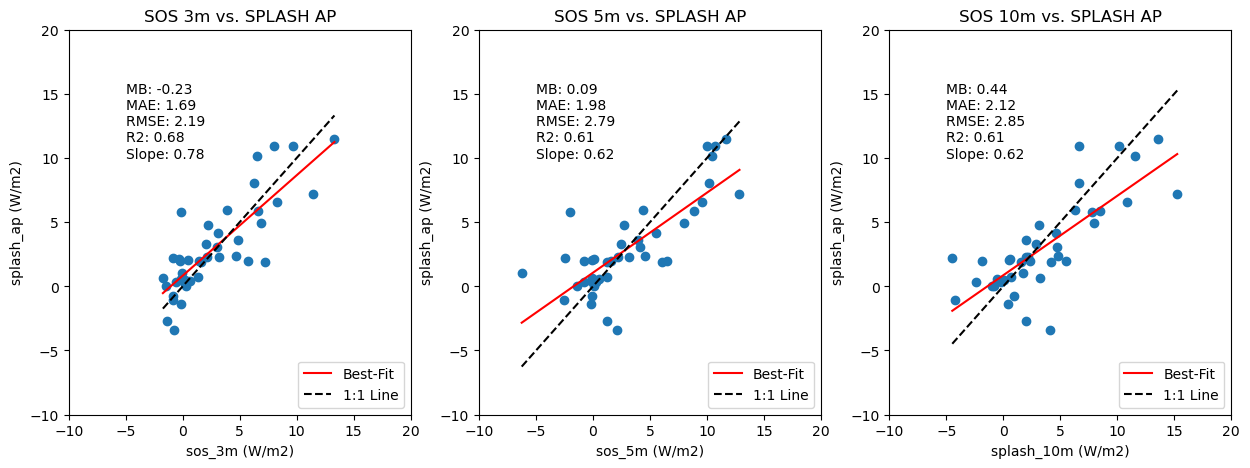

In [55]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
ax = axs[0]
# drop the max value, since it appears to define relationships
combined_periods = combined_periods.drop(combined_periods.idxmax(axis=0))
ax.scatter(combined_periods['sos_3m'], combined_periods['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_periods['sos_3m'], combined_periods['splash_ap'])
x = np.array([combined_periods['sos_3m'].min(), combined_periods['sos_3m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
# plot 1:1 line
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_3m (W/m2)')
ax.set_ylabel('splash_ap (W/m2)')
ax.set_title('SOS 3m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(combined_periods['splash_ap'], combined_periods['sos_3m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[1]
ax.scatter(combined_periods['sos_5m'], combined_periods['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_periods['sos_5m'], combined_periods['splash_ap'])
x = np.array([combined_periods['sos_5m'].min(), combined_periods['sos_5m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('sos_5m (W/m2)')
ax.set_ylabel('splash_ap (W/m2)')
ax.set_title('SOS 5m vs. SPLASH AP')
mb, mae, rmse, mpe = bias_calculations(combined_periods['splash_ap'], combined_periods['sos_5m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")

ax = axs[2]
ax.scatter(combined_periods['sos_10m'], combined_periods['splash_ap'])
# plot best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_periods['sos_10m'], combined_periods['splash_ap'])

x = np.array([combined_periods['sos_10m'].min(), combined_periods['sos_10m'].max()])
y = slope * x + intercept
ax.plot(x, y, color='red', label='Best-Fit')
ax.plot(x, x, color='black', linestyle='--', label='1:1 Line')
ax.set_xlabel('splash_10m (W/m2)')
ax.set_ylabel('splash_ap (W/m2)')
ax.set_title('SOS 10m vs. SPLASH AP')
# annotate the RMSE, R2, bias, and slope
mb, mae, rmse, mpe = bias_calculations(combined_periods['splash_ap'], combined_periods['sos_10m'])
ax.text(-5, 10, f"MB: {mb.round(2)}\nMAE: {mae.round(2)}\nRMSE: {rmse.round(2)}\nR2: {(r_value**2).round(2)}\nSlope: {slope.round(2)}")


for ax in axs:
    ax.legend(loc='lower right')
    ax.set_ylim(-10,20)
    ax.set_xlim(-10,20)

Now, let's make a linear regression between our SPLASH AP data and our SOS_3m data.

In [56]:
w23_sublimation_df_6hr_splash = resample_and_filter_df(w23_sublimation_df, 6, 0.9, dropna=False)[['splash_ap','sos_3m']]
# since splash AP is the refence, lets linearly interpret missing values
w23_sublimation_df_6hr_splash = w23_sublimation_df_6hr_splash.interpolate(method='linear', limit=1) 
# for the remaining values, put in rolling 7-day mean
w23_sublimation_df_6hr_splash = w23_sublimation_df_6hr_splash.fillna(w23_sublimation_df_6hr_splash.rolling(8,min_periods=1, center=True).mean())

In [57]:
# inputs for linear regression
x = combined_periods[['sos_3m']]
y = combined_periods['splash_ap']

# test data for the linear regression
mask = ~(w23_sublimation_df_6hr_splash['sos_3m'].isnull())
x_test = w23_sublimation_df_6hr_splash[mask][['sos_3m']]

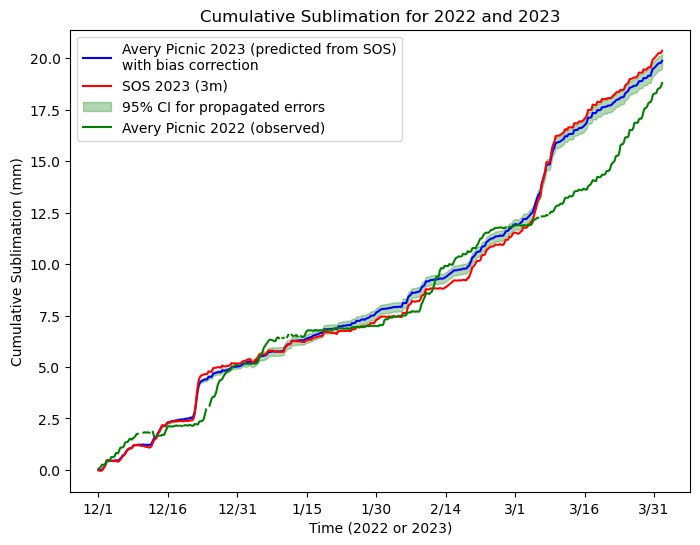

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# Fit linear regression model
model = LinearRegression().fit(x, y)

# Predict y for new x2 values
y_pred = model.predict(x_test) + 0.23

# Compute the cumulative sum for x and y
x_cumsum = x_test.cumsum()
y_cumsum = y_pred.cumsum()

# Bootstrapping for uncertainty estimation
n_bootstraps = 1000
y_bootstrap_samples = np.zeros((n_bootstraps, len(x_test)))

for i in range(n_bootstraps):
    # Resample the original data (with replacement)
    x_resampled, y_resampled = resample(x, y)
    
    # Refit the model on the resampled data
    model_resampled = LinearRegression().fit(x_resampled, y_resampled)
    
    # Predict on the new x2 values
    y_bootstrap_samples[i, :] = model_resampled.predict(x_test)

# Calculate prediction intervals (e.g., 95% confidence interval)
y_lower = np.percentile(y_bootstrap_samples, 2.5, axis=0)
y_upper = np.percentile(y_bootstrap_samples, 97.5, axis=0)

# Calculate the standard error for y
y_std_err = (y_upper - y_lower) / (2 * 1.96)  # Assuming normal distribution, 95% CI = 1.96 * std_err

# Now propagate the errors in the cumulative sum

# Step 1: Initialize arrays for propagated cumulative sum errors
y_cumsum_std_err = np.zeros(len(y_pred))

# Step 2: Assume y1 has negligible or constant standard error (if not, add those as well)
y1_std_err = np.zeros(len(y))  # Here, assuming no uncertainty in y1

# Step 3: Combine the standard errors
y_combined_std_err = np.append(y1_std_err, y_std_err)

# Step 4: Propagate the errors for the cumulative sum
for i in range(1, len(y_pred)):
    y_cumsum_std_err[i] = np.sqrt(np.sum(y_combined_std_err[:i+1] ** 2))

# Calculate the upper and lower bounds for the cumulative sum based on propagated errors
y_cumsum_lower = y_cumsum - 1.96 * y_cumsum_std_err
y_cumsum_upper = y_cumsum + 1.96 * y_cumsum_std_err

# Plot cumulative sums with propagated uncertainty
plt.figure(figsize=(8, 6))
plt.plot(x_cumsum.index, y_cumsum*(86400/4/latent_heat_sublimation), color='blue', label='Avery Picnic 2023 (predicted from SOS)\nwith bias correction')
plt.plot(x_cumsum.index, x_cumsum*(86400/4/latent_heat_sublimation), color='red', label='SOS 2023 (3m)')
plt.fill_between(x_cumsum.index, y_cumsum_lower*(86400/4/latent_heat_sublimation), y_cumsum_upper*(86400/4/latent_heat_sublimation), color='green', alpha=0.3, label='95% CI for propagated errors')

plt.plot(x_cumsum.index, (w22_sublimation_df.resample('6H').mean().cumsum().loc['2021-12-01':'2022-04-01']['splash_ap'])*(86400/4/latent_heat_sublimation), color='green', label='Avery Picnic 2022 (observed)')


plt.xlabel('Time (2022 or 2023)')
plt.ylabel('Cumulative Sublimation (mm)')
# make the xlabel the first and mid date of each month
plt.xticks(x_cumsum.index[::60], [f'{x_cumsum.index[i].month}/{x_cumsum.index[i].day}' for i in range(0, len(x_cumsum.index), 60)])

plt.legend()
plt.title('Cumulative Sublimation for 2022 and 2023')
plt.show()

# Evaluate the largest sublimation events from each year
- how do we define an event? -> Likely consective observations in the top x% of all observations

In [81]:
# open laser disdrometer data
w22_splash_ld_ds = xr.open_dataset('../../01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w22.nc')
w22_splash_ld_ds_3H_sum = w22_splash_ld_ds['corrected_prcp_rate_m2'].to_pandas().resample('3H').sum()
w23_splash_ld_ds = xr.open_dataset('../../01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w23.nc')
w23_splash_ld_ds_3H_sum = w23_splash_ld_ds['corrected_prcp_rate_m2'].to_pandas().resample('3H').sum()


In [80]:
w23_splash_ld_ds_3H_sum.describe()

count    968.000000
mean       0.648377
std        1.500056
min        0.000000
25%        0.000000
50%        0.000000
75%        0.401588
max       16.529161
dtype: float64

In [125]:
# first, lets drop the highest and lowest 1% of the data 
w22_sublimation_df_filtered = w22_sublimation_df.where((w22_sublimation_df < w22_sublimation_df.quantile(0.995)) & (w22_sublimation_df > w22_sublimation_df.quantile(0.005)) )
w23_sublimation_df_filtered = w23_sublimation_df.where((w23_sublimation_df < w23_sublimation_df.quantile(0.995)) & (w23_sublimation_df > w23_sublimation_df.quantile(0.005)))

# second, create the 3-hour product, and only keep the splash columns
w22_sublimation_df_filtered_3H= w22_sublimation_df_filtered['splash_ap'].resample('3H').mean().dropna()
w23_sublimation_df_filtered_3H= w23_sublimation_df_filtered['sos_3m'].resample('3H').mean().dropna()

# for each year, let's get some statistics about big sublimation events
# First, let's look at all observations and determine a threshold for a big event
w22_70th_percentile = np.percentile(w22_sublimation_df_filtered_3H, 70)
w23_70th_percentile = np.percentile(w23_sublimation_df_filtered_3H, 70)

w22_95th_percentile = np.percentile(w22_sublimation_df_filtered_3H, 95)
w23_95th_percentile = np.percentile(w23_sublimation_df_filtered_3H, 95)

prcp_threshold = 12.5
# A big event will be defined as anytime more than 4 consective observations are above the 70th percentile
# let's filter to only those events
def identify_large_sublimation_events(df, df_prcp, threshold_long, threshold_short):
    """
    Identify large sublimation events in the dataframe
    """
    long_events = []
    spiky_events = []
    # iterate through each row to determine if 
    for i in range(len(df)):
        if df.iloc[i] > threshold_short:
            # check to see how many consecutive values are above the threshold
            j = i
            while (j < len(df)) and (df.iloc[j] > threshold_short) and (df_prcp.iloc[j] < prcp_threshold):
                j += 1
            if (j-i > 1 ) & (j-i<=4):
                spiky_events.append(df.iloc[i:j])
                continue
        elif (df.iloc[i]) > threshold_long:
            # check to see how many consecutive values are above the threshold
            j = i
            while (j < len(df)) and (df.iloc[j] > threshold_long) and (df_prcp.iloc[j] < prcp_threshold):
                j += 1
            if j-i > 4:
                long_events.append(df.iloc[i:j])

    # make sure there are no repeats
    long_events_df = pd.concat(long_events).drop_duplicates()
    # separate into individual events
    long_events = [long_events_df.iloc[i:j] for i, j in zip(np.where(long_events_df.index.to_series().diff().dt.total_seconds() > 6*3600)[0], np.where(long_events_df.index.to_series().diff().dt.total_seconds() > 6*3600)[0][1:])]
    # add in the first event
    long_events.insert(0, long_events_df.iloc[:np.where(long_events_df.index.to_series().diff().dt.total_seconds() > 12*3600)[0][0]])
    # add in the last event
    long_events.append(long_events_df.iloc[np.where(long_events_df.index.to_series().diff().dt.total_seconds() > 12*3600)[0][-1]:])
    # double check that long events are long enough
    long_events = [event for event in long_events if len(event) > 4]
    # double check that the mean is above the percentile
    long_events = [event for event in long_events if event.median() > threshold_long]
    # spiky events
    spiky_events_df = filter_spiky_events(spiky_events,long_events)
    # separate into individual events
    spiky_events = [spiky_events_df.iloc[i:j] for i, j in zip(np.where(spiky_events_df.index.to_series().diff().dt.total_seconds() > 12*3600)[0], np.where(spiky_events_df.index.to_series().diff().dt.total_seconds() > 12*3600)[0][1:])]
    # add in the first event
    spiky_events.insert(0, spiky_events_df.iloc[:np.where(spiky_events_df.index.to_series().diff().dt.total_seconds() > 12*3600)[0][0]])
    # add in the last event
    spiky_events.append(spiky_events_df.iloc[np.where(spiky_events_df.index.to_series().diff().dt.total_seconds() > 12*3600)[0][-1]:])
    return spiky_events, long_events

def filter_spiky_events(spiky_list, long_list):
    df_spiky = pd.concat(spiky_list)
    df_long = pd.concat(long_list)
    # remove any spiky events that are within a long event
    df_spiky = df_spiky[~df_spiky.index.isin(df_long.index)].drop_duplicates()
    # return to list
    return df_spiky
w22_large_sublimation_spiky_events, w22_large_sublimation_long_events = identify_large_sublimation_events(w22_sublimation_df_filtered_3H, w22_splash_ld_ds_3H_sum, w22_70th_percentile, w22_95th_percentile)
w23_large_sublimation_spiky_events, w23_large_sublimation_long_events = identify_large_sublimation_events(w23_sublimation_df_filtered_3H, w23_splash_ld_ds_3H_sum, w23_70th_percentile, w23_95th_percentile)

In [126]:
# make a line of the cdf
def id_quantile_value(data, value):
    # Sort the data
    sorted_data = pd.Series(np.sort(data))
    # Calculate the quantiles
    yvals = pd.Series(np.arange(1000)/float(len(sorted_data)-1))
    # find the value
    idx = np.argmin(np.abs(sorted_data - value))
    return yvals[idx]

In [127]:
# for each event, get the length and the percentile of the mean value
w22_long_event_lengths = [len(event)*3 for event in w22_large_sublimation_long_events]
w23_long_event_lengths = [len(event)*3 for event in w23_large_sublimation_long_events]
# if length > 24, set value to 24
w22_long_event_lengths = [24 if event > 24 else event for event in w22_long_event_lengths]
w23_long_event_lengths = [24 if event > 24 else event for event in w23_long_event_lengths]
# short event lengths
w22_spiky_event_lengths = [len(event)*3 for event in w22_large_sublimation_spiky_events]
w23_spiky_event_lengths = [len(event)*3 for event in w23_large_sublimation_spiky_events]

# get the percentiles
w22_long_event_percentiles = [id_quantile_value(w22_sublimation_df_filtered_3H, event.mean())*100 for event in w22_large_sublimation_long_events]
w23_long_event_percentiles = [id_quantile_value(w23_sublimation_df_filtered_3H, event.mean())*100 for event in w23_large_sublimation_long_events]
w22_spiky_event_percentiles = [id_quantile_value(w22_sublimation_df_filtered_3H, event.mean())*100 for event in w22_large_sublimation_spiky_events]
w23_spiky_event_percentiles = [id_quantile_value(w23_sublimation_df_filtered_3H, event.mean())*100 for event in w23_large_sublimation_spiky_events]


### Let's  make a visualization for event size

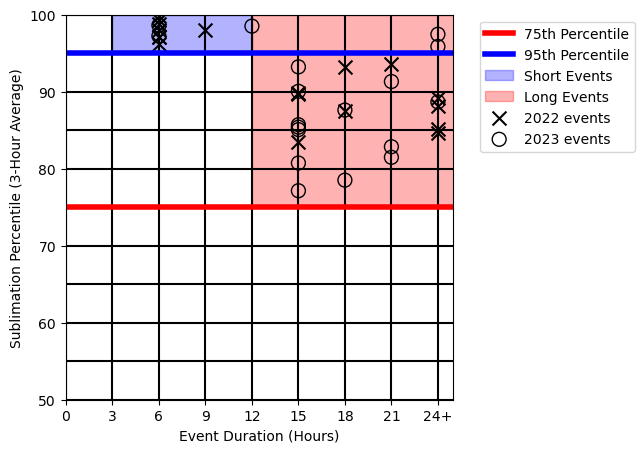

In [128]:
# visualization for event size, x axis will be duration of event, y-axis will be percentile threshold of event
x = np.arange(0,30,3)
y = np.arange(50, 101, 5)
# make a grid to plot
X, Y = np.meshgrid(x, y)
xlabels = [i for i in np.arange(0,27,3)]
# replace the last values with 24+
xlabels[-1] = '24+'

# plot the grid as lines
fig, ax = plt.subplots(1,1, figsize=(5,5))
# plot the vertical lines
for i in x:
    ax.axvline(i, color='black', linestyle='-')
for i in y:
    ax.axhline(i, color='black', linestyle='-')
# add threshold lines
ax.axhline(75, color='red', label='75th Percentile', lw=4)
ax.axhline(95, color='blue', label='95th Percentile', lw=4)
# shade the grid below 12 hours and above 90th percentile for short events
ax.fill_between(x[(x<=12) & (x>=3)], 95, 100, color='blue', alpha=0.3, label='Short Events')
# shade the grid above 12 hours and above 75th percentile for long events
ax.fill_between(x[x>=12], 75, 100, color='red', alpha=0.3, label='Long Events')
# make the x-ticks by 6 and then 24 is 24 hours +
ax.set_xticks(np.arange(0,27,3))
ax.set_xticklabels(xlabels)
# set labels
ax.set_xlabel('Event Duration (Hours)')
ax.set_ylabel('Sublimation Percentile (3-Hour Average)')
# set axis limits
ax.set_ylim(50,100)
ax.set_xlim(0,25)


# plot the long events
ax.scatter(w22_long_event_lengths, w22_long_event_percentiles, marker='x', s=100, color='black', label='2022 events')
ax.scatter(w23_long_event_lengths, w23_long_event_percentiles, marker='o', s=100, facecolors='none', color='black', label='2023 events')
# plot the spiky events
ax.scatter(w22_spiky_event_lengths, w22_spiky_event_percentiles, marker='x', color='black', s=100)
ax.scatter(w23_spiky_event_lengths, w23_spiky_event_percentiles, marker='o', facecolors='none', color='black', s=100)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

354
234
average length of event 2023: 23.599999999999998
average length of event 2022: 23.4
total sublimation 2023: 9.159528419287366
total sublimation 2022: 5.487331619795738


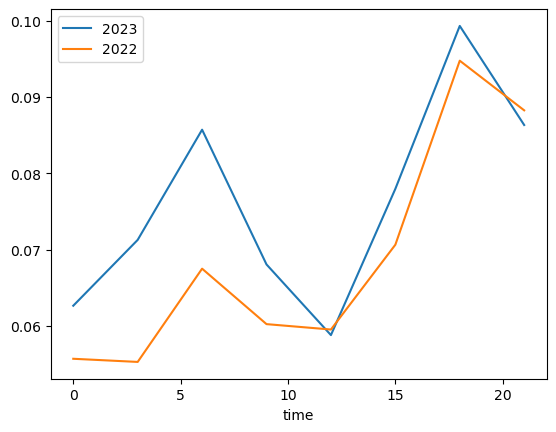

In [129]:
df_23 = pd.concat(w23_large_sublimation_long_events).drop_duplicates().sort_index()*86400/latent_heat_sublimation/8
df_22 = pd.concat(w22_large_sublimation_long_events).drop_duplicates().sort_index()*86400/latent_heat_sublimation/8
fig, ax = plt.subplots()
df_23.groupby(df_23.index.hour).mean().plot(ax=ax, label='2023')
df_22.groupby(df_22.index.hour).mean().plot(ax=ax, label='2022')
print(len(df_23)*3)   
print(len(df_22)*3)
print('average length of event 2023:', np.array([len(df) for df in w23_large_sublimation_long_events]).mean()*3)
print('average length of event 2022:', np.array([len(df) for df in w22_large_sublimation_long_events]).mean()*3)
print('total sublimation 2023:', df_23.sum())
print('total sublimation 2022:', df_22.sum())
ax.legend()

# Start Here
- need to classify these spiky events better

24
51
average length of event 2023: 8.0
average length of event 2022: 6.375
total sublimation 2023: 1.2797683241737503
total sublimation 2022: 2.037387336921771


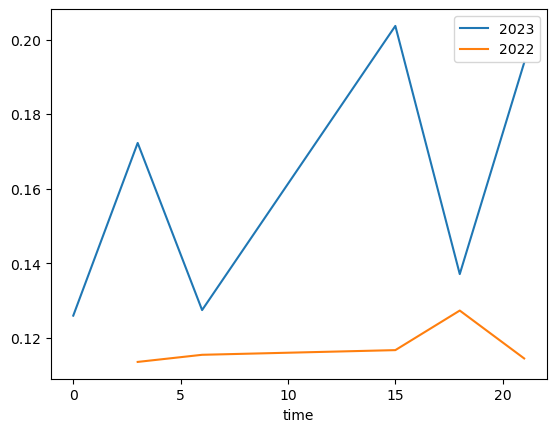

In [100]:
df_23 = pd.concat(w23_large_sublimation_spiky_events).drop_duplicates().sort_index()*86400/latent_heat_sublimation/8
df_22 = pd.concat(w22_large_sublimation_spiky_events).drop_duplicates().sort_index()*86400/latent_heat_sublimation/8
fig, ax = plt.subplots()
df_23.groupby(df_23.index.hour).mean().plot(ax=ax, label='2023')
df_22.groupby(df_22.index.hour).mean().plot(ax=ax, label='2022')
print(len(df_23)*3)   
print(len(df_22)*3)
print('average length of event 2023:', np.array([len(df) for df in w23_large_sublimation_spiky_events]).mean()*3)
print('average length of event 2022:', np.array([len(df) for df in w22_large_sublimation_spiky_events]).mean()*3)
print('total sublimation 2023:', df_23.sum())
print('total sublimation 2022:', df_22.sum())
ax.legend()

In [359]:
# for each event calculate the sum
events = []
for event in w23_large_sublimation_spiky_events:
    events.append([event.index[0], event.index[-1]])
    print(event.sum()*86400/latent_heat_sublimation/8)

0.2702699950777985
0.6687826640404215
0.34071566505553025
